In [1]:
## TODO
# calcul de V avc diff Q0, (et B)
# comparaison avec cout

In [2]:
### intro :
# - 2, 3 p sur le contrôle, sur-martingale, drift, dynamic programming (critère sur-martingale !), 
# optimum doit être 0 pour être martingale (book au lieu de poly + finite fuel control),
# (optimization atypique : opt au temps d'atteinte au lieu de horizon fini et infini)

###
# Fair : Mohamed ou Christophe
# contrôle sto: voir Marcos

In [3]:
## petites notes:
# b < BMAX - B
# discr Q >> discr B (B big discr)
# prod matr instead of vec/scalar

# rapporteurs:
#    chercheurs **spécialiste** du domaine qui font des rapports. Suffisant pour soutenir devant un jury ?
#    c'est eux qui valident le contenu (originalité des résultats) dans un délai de 2-3 mois à envoyer à l'ED.
#    Ils donnent l'autorisation de soutenir. (une personne de IP Paris, une personne externe)
#    Pour la carrière enseignant chercheur: ils suivent dans le dossier de candidature.
# jurys:
#    ils lisent mais pas dans le même détail


# Caroline Hillairet (Directrice de thèse)
# Christophe Dutang (Rapporteur)
# Olivier Wintenberger (Rapporteur),

# Arthur Charpentier (Examinateur, externe)
# Stéphane Loisel (Examinateur, externe),
# Christian Y. Robert (Examinateur, interne), 

# Marc Juillard (invité),
# Romuald Elie (Co-directeur de thèse et invité)


## Vianney Perchet (invité) ?
## Katrien Antonio ? (Examinateur, externe) (en anglais)
## Pierre Alquier ? (Examinateur, externe) (Attention, décalage horaire avec Canada), 


# Dynamic Batch Mode Active Learning : Experimentations

In [4]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## 1. Reminder: Dynamic Programming and Hamilton Jacobi Bellman equation

### 1.1. The optimal feedback control

Let denote by $\tau$ the first time where $B$ hits $B_{MAX}$. If ever $Q$ were able to reach $0$ or $1$, it would remain there,

$$
\tau = \inf \left\{ t\ge 0 \quad\;|\;\quad B_t = B_{Max} \;\; \mbox{or}  \;\;Q_t = 0 \;\; \mbox{or}  \;\;Q_t = 1  \right\}
$$

DDP implies

$$
v(Q_{t},B_{t})  =   \sup_{b_s, \; s \in  [t,(t+h)\wedge\tau]} \mathbb{E}[ v(Q_{t+h},B_{t+h}) - \int_{t}^{t+h} c(b_s)ds  | \mathcal{F}_t ]
$$


The function $v$ (if regular enough) should satisfy as well

\begin{eqnarray*}
 v(0+,B) &=& U(0)\\
 v(1-,B) &=& U(1) 
\end{eqnarray*}


We recall the dynamics of the state processes $(Q_t,B_t)$.

\begin{equation*}
\left\{
    \begin{array}{ll}
        dQ_t = \mu(B_t, b_t)\cdot Q_t(1-Q_t)\cdot dt + \sigma(B_t, b_t)\cdot Q_t(1-Q_t)\cdot dW_t\\
        dB_t = b_t \cdot dt
    \end{array}
\right.
\end{equation*}

the HJB equation in the interior of the domain  $[0,1]\times[0,B_{max}]$ rewrites 

\begin{eqnarray}\label{eq:HJB_Interior}
 \sup_{b\ge 0} \left\{ \mu(B,b) Q (1-Q) \frac{\partial v}{\partial Q} (Q,B) + b \frac{\partial v}{\partial B} (Q,B) + \frac{1}{2}\sigma(B,b)^2 Q^2 (1-Q)^2 \frac{\partial^2 v}{\partial Q^2} (Q,B) -c(b) \right\} = 0
\end{eqnarray}

together with the boundary condition

\begin{eqnarray}\label{eq:HJB_Boundary}
 v(Q,B_{max}) &=& U(Q)  \quad \mbox{for} \quad  Q\in (0,1) 
\end{eqnarray}

The optimal control $b^*$ as a function of $(Q,B)$ is the optimizer.

Let us denote

$$
A(B, b, Q) = \mu(B,b) Q (1-Q) \frac{\partial v}{\partial Q} (Q,B) + b \frac{\partial v}{\partial B} (Q,B) + \frac{1}{2}\sigma(B,b)^2 Q^2 (1-Q)^2 \frac{\partial^2 v}{\partial Q^2} (Q,B) -c(b)
$$

### 1.2. EDP approximation by finite diffrence and Howard algorithm

One approximation of $A$ (by finite difference) is

<font color=red>
$$
\hat{A}(B, b, Q, v_{i-1, j}) = \mu(B,b) Q (1-Q) \frac{v_{i, j+1}-v_{i,j}}{dQ} + b \frac{v_{i,j}-v_{i-1, j}}{dB} + \frac{1}{2}\sigma(B,b)^2 Q^2 (1-Q)^2 \frac{v_{i, j+1}-2v_{i,j}+v_{i,j-1}}{dQ^2} -c(b)
$$
</font>

Therefore we have the following empirical relation,

<font color=red>
$$
 \sup_{b\ge 0, b\le B_{MAX}-B} \left\{\hat{A}(B, b, Q, v_{i-1, j})\right\} = 0
$$
</font>


with $v_{i, j} = v(B_{i}, Q_j)$.

**Here the problem is to find $b^*$ realizing the above expression. $b^*$ should be dependant to $v_{i-1,\cdot}$**

<font color=red>
\begin{equation*}
\left\{
    \begin{array}{ll}
        b^* = \arg\sup\limits_{b\ge 0, b\le B}\left\{\mu(B,b) Q (1-Q) \frac{v_{i, j+1}-v_{i,j}}{dQ} + b \frac{v_{i,j}-v_{i-1, j}}{dB} + \frac{1}{2}\sigma(B,b)^2 Q^2 (1-Q)^2 \frac{v_{i, j+1}-2v_{i,j}+v_{i,j-1}}{dQ^2} -c(b) \right\}\\
    v_{i-1, j} = \frac{dB}{b^*}\left(\mu(B,b^*)Q(1-Q)\frac{v_{i,j+1}-v_{i,j}}{dQ} + \frac{1}{2}\sigma(B, b^*)^2Q^2(1-Q)^2\frac{v_{i,j+1}-2v_{i,j}+v_{i,j-1}}{dQ^2} - c(b^*) \right) + v_{i,j}
    \end{array}
\right.
\end{equation*}
</font>

For each $(B, Q)$ we can use the **Howard algorithm**:

**STEP 1:** start with an initial value $b^0$. Compute the solution $u^{0}$ of $\hat{A}(B, b^0, Q, u^{0}) = 0$ i.e.

\begin{equation*}
u^{0} = \frac{dB}{b^0}\left(\mu(B,b^0)Q(1-Q)\frac{v_{i,j+1}-v_{i,j}}{dQ} + \frac{1}{2}\sigma(B, b^0)^2Q^2(1-Q)^2\frac{v_{i,j+1}-2v_{i,j}+v_{i,j-1}}{dQ^2} - c(b^0) \right) + v_{i,j}
\end{equation*}

**STEP 2 ($k$ to $k+1$):** given $u^{k}$, find $b^{k+1}$ maximizing

\begin{equation*}
\sup\limits_{b\ge 0, b\le B_{MAX}-B}\left\{\mu(B,b) Q (1-Q) \frac{v_{i, j+1}-v_{i,j}}{dQ} + b \frac{v_{i,j}-u}{dB} + \frac{1}{2}\sigma(B,b)^2 Q^2 (1-Q)^2 \frac{v_{i, j+1}-2v_{i,j}+v_{i,j-1}}{dQ^2} -c(b) \right\}
\end{equation*}

compute the solution $u^{k+1}$ of $\hat{A}(B, b^{k+1}, Q, u^{k+1}) = 0$

**FINAL STEP:** if $|u^{k+1}-u^{k}|<\epsilon$, then set $v_{i,j-1} = u^{k+1}$ else go to STEP 2.





**Remark:** can we guarantee the convergence ?

## 2. Numerical analysis

### 2.0. Librairies and parameters

In [5]:
# LIBRAIRIES
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import gridspec
import random

In [6]:
# NUMERICAL PARAMETERS (20, 100)
NQ   = 20    #Number of grid points
BMAX = 500   #Number of labeled points
dQ_step = 1/(NQ)  #Grid step
dB_step = 1       #Grid step
b_batch = 10

### 2.1. Main functions and algorithms

In [7]:
# MAIN FUNCTION PARAMETERS
BETAC = 10**(-6) # (1/BW)*10**(-6) #5*10**(-6) # 0.0005
BETAS = 0.05      # np.sqrt(1/BW)*0.005
BETAM = 0.05       # (1/BW)*0.05
P = 0.9

BW = 1
ALPHAC = 0 #0
D = 2

def U(Q, p=P):
    return (Q**p)

def sigma(B, b, betas=BETAS, bw=BW):
    return betas*(bw*b/(B)) * (B+bw*b>0)#betas*(bw*b/(B+bw*b)) * (B+bw*b>0)

def mu(B, b, betam=BETAM, bw=BW):
    return betam*(bw*b/(B)) * (B+bw*b>0)#betam*(bw*b/(B+bw*b)) * (B+bw*b>0)

def cost(b, betac=BETAC, d=D, alphac=ALPHAC):
    return alphac + betac * b**d#np.array(0)*b#

In [8]:
# PLOTS
from matplotlib.patches import Rectangle

def viz_heatmap(b_optimal, title="", btr_i=None, btr_j=None, BMAX=BMAX, ax=None):
    fig, ax = plt.subplots(figsize=(6, 4))
    b_optimal_copy = b_optimal.copy()
    pos = ax.imshow(b_optimal_copy, cmap='YlGnBu_r', interpolation='nearest', aspect='auto') # "hot"
    add_title = ""
    if btr_i is not None or btr_j is not None:
        for i, j in zip(btr_i, btr_j):
            #print(i, j)
            ax.add_patch(Rectangle((j, i), 0.5, 1, fill=False, edgecolor='crimson', lw=2))
        add_title += ",\nSimulated trajectory is highlighted in red"
    ax.set_title(f"{title} w.r.t. (Q, B)"+add_title, fontsize=15)
    ax.set_xlabel(u"$Q$", fontsize=15)
    ax.set_ylabel(u"$B$", fontsize=15)
    ax.set_xticks([0, b_optimal.shape[1]//2, b_optimal.shape[1]])
    ax.set_xticklabels([0, 0.5, 1])
    ax.set_yticks([0, b_optimal.shape[0]//2, b_optimal.shape[0]])
    ax.set_yticklabels([0, BMAX//2, BMAX])
    fig.colorbar(pos, ax=ax)
    return ax

def heatmap_by_param(optimal_by_param, betac=".", betam=".", betas=".", p=".", bw="."):
    ncol = 3
    interval = optimal_by_param["interval"]
    param_name = optimal_by_param["param_name"]
    for val in optimal_by_param["values"]:
        fig = plt.figure(figsize=(16, 6))
        spec = gridspec.GridSpec(ncols=ncol, nrows=len(interval)//ncol + 1, wspace=0.2, hspace=0.5)
        for i, beta in enumerate(interval):
            ax1 = fig.add_subplot(spec[i])
            optimal = optimal_by_param["values"][val][i].copy()
            
            o90 = np.quantile(np.ndarray.flatten(optimal), q=0.9)
            optimal[optimal > o90] == o90
            
            pos = ax1.imshow(optimal, cmap='YlGnBu_r', interpolation='nearest', aspect='auto') # "hot"
            title_name = f"{val}, {param_name}={round(beta, 7)}\n"
            if param_name=="betac":
                title_name += f"p={p}, beta_m,s=({round(betam, 7)}, {round(betas, 7)})"
            if param_name=="betam":
                title_name += f"p={p}, beta_c,s=({round(betac, 7)}, {round(betas, 7)})"
            if param_name=="betas":
                title_name += f"p={p}, beta_c,m=({round(betac, 7)}, {round(betam, 7)})"
            if param_name=="p":
                title_name += f"beta_c,m,s=({round(betac, 7)}, {round(betam, 7)}, {round(betas, 7)})"
            if param_name=="bw":
                title_name += f""
            ax1.set_title(title_name, fontsize=10)
            ax1.set_xlabel(u"$Q$", fontsize=12)
            ax1.set_ylabel(u"$B$", fontsize=12)
            ax1.set_xticks([0, optimal.shape[1]//2, optimal.shape[1]])
            ax1.set_xticklabels([0, 0.5, 1])
            fig.colorbar(pos, ax=ax1)
            
def viz_main_functions(BMAX, NQ):
    fig = plt.figure(figsize=(16, 3))
    spec = gridspec.GridSpec(ncols=4, nrows=1, wspace=0.45,
                             hspace=0.3)#, height_ratios=[1, 2])
    #spec = gridspec.GridSpec(ncols=4, nrows=1, wspace=0.3,
    #                         hspace=0.3)#, height_ratios=[1, 2])
    ax1 = fig.add_subplot(spec[0])
    ax2 = fig.add_subplot(spec[1])
    ax3 = fig.add_subplot(spec[2])
    ax4 = fig.add_subplot(spec[3])
    #ax5 = fig.add_subplot(spec[4], projection='3d')
    #ax6 = fig.add_subplot(spec[5], projection='3d')

    bs = np.arange(0, BMAX)
    qs = np.linspace(0, 1, NQ)
    yc = cost(bs)
    yu = U(qs)
    ys = sigma(BMAX, bs)
    ym = mu(BMAX, bs)

    ax1.plot(qs, yu)
    ax1.set_ylabel(u"$U(Q)$", fontsize=15)
    ax1.set_xlabel(u"$Q$", fontsize=15)
    ax1.set_title(u"$Q^p$", fontsize=12)

    ax2.plot(bs, yc)
    ax2.set_ylabel(u"$cost(b)$", fontsize=15)
    ax2.set_xlabel(u"$b$", fontsize=15)
    ax2.set_title(u"$beta_c \ b^2$", fontsize=12)

    ax3.plot(bs, ym)
    ax3.set_ylabel(u"$\mu(B_{MAX}, b)$", fontsize=15)
    ax3.set_xlabel(u"$b$", fontsize=15)
    ax3.set_title(u"$beta_m b/B$", fontsize=12)#$beta_m$ $b/(b+B)$

    ax4.plot(bs, ys)
    ax4.set_ylabel(u"$\sigma(B_{MAX}, b)$", fontsize=15)
    ax4.set_xlabel(u"$b$", fontsize=15)
    ax4.set_title(u"$beta_s b/B$", fontsize=12)#$beta_s$ $(1-b/(b+B))$
    
    #def U(Q, p=P):
    #    return (Q**p)
    #
    #def sigma(B, b, betas=BETAS, bw=BW):
    #    return betas*(bw*b/(B+bw*b)) * (B+bw*b>0)
    #
    #def mu(B, b, betam=BETAM, bw=BW):
    #    return betam*(bw*b/(B+bw*b)) * (B+bw*b>0)
    #
    #def cost(b, betac=BETAC, d=D, alphac=ALPHAC):
    #    return alphac + betac * b**d
    
    #Bm = np.arange(1, BMAX)
    #bm = np.arange(1, BMAX)
    #B_mesh, b_mesh = np.meshgrid(Bm, bm)
    #Z_sigma = sigma(B_mesh, b_mesh)
    #Z_mu = mu(B_mesh, b_mesh)
#
    #ax5.contour3D(B_mesh, b_mesh, Z_sigma, 100, alpha= 0.8, cmap=cm.coolwarm)
    #ax5.set_xlabel(u'$B$', fontsize=15)
    #ax5.set_ylabel(u'$b$', fontsize=15)
    #ax5.set_zlabel(u'$\sigma(B, b)$', fontsize=15)
    ##for angle in range(0, 180):
    ##    ax5.view_init(45, angle)
#
    #ax6.contour3D(B_mesh, b_mesh, Z_mu, 100, alpha= 0.8, cmap=cm.coolwarm)#cm.coolwarm)
    #ax6.set_ylabel(u"$B$", fontsize=15)
    #ax6.set_xlabel(u"$b$", fontsize=15)
    #ax6.set_zlabel(u'$\mu(B, b)$', fontsize=15);
    ##plt.tight_layout(h_pad=4);

In [9]:
# use the Howard algorithm !! page 197 !!
## MAIN ALGORITHM
def optimal_batch(dQ_step,
                  dB_step,
                  Bmax,
                  print_res = True,
                  print_steps = True,
                  plot_distrib = True,
                  eps = 0.0001,
                  n_iterations = 10,
                  n_explosions = 20,
                  n_print_coeffs = 0,
                  betac = 0.00025,
                  betam = 0.5,
                  betas = 0.5,
                  p = 0.9,
                  bw = 2):
    cut = 6
    
    # Initialisation
    Qs = np.arange(0, 1+dQ_step, dQ_step)
    Bs = np.arange(1, Bmax+dB_step-1, dB_step)
    V = np.zeros((len(Bs), len(Qs)))

    # conditions aux bords
    V[len(Bs)-1, :] = U(Qs, p)
    V[:, 0] = U(0.01, p)#U(0.01, p)
    V[:, -1] = U(0.99, p)#U(0.99, p)
    
    # functions
    def Ufunction(B, b, Q, V, i, j):
        return mu(B,b,betam,bw)*Q*(1-Q)*(V[i,j]-V[i,j-1])/dQ_step + (V[i,j]-V[i-1,j])*b/dB_step + 0.5*sigma(B,b,betas,bw)**2 * Q**2 * (1-Q)**2 * (V[i,j+1]-2*V[i,j]+V[i,j-1])/(dQ_step**2)
    
    def Afunction(B, b, Q, V, i, j):
        return Ufunction(B, b, Q, V, i, j) - cost(b, betac=betac) #OK
        #return np.abs(Ufunction(B, b, Q, V, i, j)) - cost(b, betac=betac) #TEST

    def Vfunction(B, b_opt, Q, V, i, j):
        res = (dB_step/b_opt)*(mu(B,b_opt,betam,bw)*Q*(1-Q)*(V[i,j]-V[i,j-1])/dQ_step + 0.5*sigma(B,b_opt,betas,bw)**2 * Q**2 * (1-Q)**2 * (V[i,j+1]-2*V[i,j]+V[i,j-1])/(dQ_step**2) - cost(b_opt, betac=betac) ) + V[i,j]
        #res = np.minimum(res, U(0.99))
        #res = np.maximum(res, U(0.01))
        return res
    if n_print_coeffs > 0:
        plt.figure(figsize=(16, 2*(1 + n_print_coeffs//cut)))
    
    #print("Shape of V:", V.shape)
    b_optimal = np.zeros((len(Bs), len(Qs)))
    b_optimal_over_B = np.zeros((len(Bs), len(Qs)))
    b_ratio_notconv = []
    b_ratio_conv = []
    n_expl = 0
    n_coef = 0
    n_coef_count = 0
    keep_i = []
    keep_j = []
    
    for i, B in list(enumerate(Bs[:-1], start=1))[::-1]:
        bs = np.arange(dB_step, Bmax-B+dB_step, dB_step)#np.arange(1, Bmax-B+dB_step, dB_step)#
        #print(bs.shape, Bmax-B)
        for j, Q in list(enumerate(Qs[1:-1], start=1))[::-1]:
            n_iter = 0
            # STEP 1
            b_k = random.choice(bs)
            u_k = Vfunction(B, b_k, Q, V, i, j)
            # STEP 2
            while True:
                V[i-1, j] = u_k
                n_iter += 1
                # compute b^{k+1}
                A_hat = Afunction(B, bs, Q, V, i, j)
                ind_max = np.argmax(A_hat)
                b_k = bs[ind_max]
                # compute u^{k+1}
                u_k = Vfunction(B, b_k, Q, V, i, j)
                if np.abs(V[i-1, j] - u_k) < eps:
                    #u_k = np.minimum(u_k, U(0.99))
                    #u_k = np.maximum(u_k, U(0.01))
                    if u_k >= 1 and print_steps and n_expl < n_explosions:
                        n_expl += 1
                        print(f"coord={(i, j)}\t, v={round(u_k, 2)}, vneigh=({round(V[i, j+1], 2)},{round(V[i, j], 2)},{round(V[i, j-1], 3)})\t, b={b_k}\t, A_hat[ind_max]={A_hat[ind_max].round(2)}\t, n_iter={n_iter}\t, n_expl={n_expl}")
                    
                    if n_coef < n_print_coeffs and n_coef_count == 0:
                        keep_i.append(i)
                        keep_j.append(j)
                        n_coef_count += 1
                        plt.subplot((1+n_print_coeffs//cut), cut+1, 1)
                        plt.plot(bs, Ufunction(B, bs, Q, V, i, j), label=f"$U$")
                        plt.plot(bs, cost(bs,betac=betac), label=f"$C$")
                        plt.scatter(b_k, Ufunction(B, b_k, Q, V, i, j), color="red")
                        plt.scatter(b_k, cost(b_k,betac=betac), color="red")
                        plt.title(f"v={round(u_k, 2)},\n(B,Q)={(round(B, 0),round(Q, 3))}", fontsize=10)
                        plt.legend()
                    if (n_coef < n_print_coeffs and u_k >= 1) or (0 < n_print_coeffs and i==len(Bs)//2 and j==len(Qs)//2) or (u_k < 0 and n_coef < n_print_coeffs):
                        keep_i.append(i)
                        keep_j.append(j)
                        n_coef += 1
                        plt.subplot((1+n_print_coeffs//cut), cut+1, n_coef+1)
                        plt.plot(bs, Ufunction(B, bs, Q, V, i, j), label=f"$U$") # concave in b
                        plt.plot(bs, cost(bs,betac=betac), label=f"$C$") # concave in b
                        plt.scatter(b_k, Ufunction(B, b_k, Q, V, i, j), color="red")
                        plt.scatter(b_k, cost(b_k,betac=betac), color="red")
                        plt.title(f"v={round(u_k, 2)},\n(B,Q)={(round(B, 0),round(Q, 3))}", fontsize=10)
                        plt.legend()
                        #print(f"coord={(i, j)}\t, A={round(Afunction(B, b_k, Q, V, i, j), 6)}\t, cost={round(cost(b_k,betac=betac), 6)}\t, n_coef={n_coef}")
                    
                    V[i-1, j] = u_k
                    b_opt = b_k
                    b_ratio_conv.append(b_opt/(Bmax-B))
                    break

                if n_iter > n_iterations:
                    V[i-1, j] = u_k
                    b_opt = b_k
                    b_ratio_notconv.append(b_opt/(Bmax-B))
                    break

            b_optimal[i, j] = b_opt
            b_optimal_over_B[i, j] = b_opt/(Bmax-B)
    if print_res:
        print("-------------------------------------------")
        print("----------------- RESULTS -----------------")
        print("-------------------------------------------")
        print("b optimal:\n", b_optimal)
        print("b/B optimal:\n", b_optimal_over_B)
        print("b unique values:\n", np.unique(b_optimal))
        print("V values:\n", V)
    if n_print_coeffs > 0:
        #plt.tight_layout();
        plt.show()
    if plot_distrib:
        plt.figure(figsize=(16, 3))
        plt.subplot(1, 2, 1)
        plt.hist(b_ratio_conv)
        plt.xlabel("b/(BMAX-B)")
        plt.ylabel("count")
        plt.title(u"Distribution of $b/(BMAX-B)$ (convergence of the method)")
        plt.subplot(1, 2, 2)
        plt.hist(b_ratio_notconv)
        plt.xlabel("b/(BMAX-B)")
        plt.ylabel("count")
        plt.title(u"Distribution of $b/(BMAX-B)$ (non convergence of the method)");
        
    return b_optimal, b_optimal_over_B, V, keep_i, keep_j

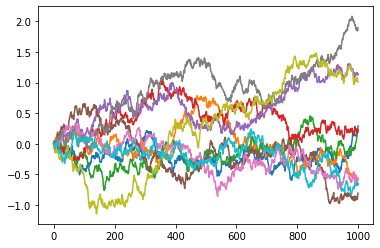

In [10]:
class Brownian():
    """
    A Brownian motion class constructor
    """
    def __init__(self,x0=0):
        """
        Init class
        """
        assert (type(x0)==float or type(x0)==int or x0 is None), "Expect a float or None for the initial value"
        
        self.x0 = float(x0)
    
    def gen_normal(self,n_step=100):
        """
        Generate motion by drawing from the Normal distribution
        """
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step)*self.x0
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution
            yi = np.random.normal()
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w
    
def stochastic_simulation(b_optimal, B0=1, Q0=0.5, n=100, T=10, n_print_coeffs=0):
    """
    Generate the state processes simulation
    """
    
    dt = T/n
    Br = Brownian()
    dW = 2*Br.gen_normal(n)
    
    NB, NQ = b_optimal.shape
    dQ_step = 1/NQ
    dB_step = 1
    Qs = np.arange(0, 1+dQ_step, dQ_step)
    Bs = np.arange(1, NB+dB_step, dB_step)
    
    b0 = B0
    B = list()
    Q = list()
    b = list()
    btr_i = list()
    btr_j = list()

    B.append( B0 )
    Q.append( Q0 )
    b.append( b0 )
    bi = np.where(B[0] <= Bs)[0][0]+1
    bj = np.where(Q[0] <= Qs)[0][0]-1
    btr_i.append( bi )
    btr_j.append( bj )
    b.append( int(b_optimal[bi, bj]) )
    #print(b)        
    
    t = 1
    while B[t-1] + b[t] < int(NB*dB_step) and Q[t-1] > 0 and Q[t-1] < 1 and t < int(NB*dB_step) and b[t] > 0:
        try:
            B.append( int(B[t-1] + b[t]) ) # HERE instead of dBt = bt*dt we choose dBt = bt
            Q.append( Q[t-1] + mu(B[t-1],b[t])*Q[t-1]*(1-Q[t-1])*dt + sigma(B[t-1],b[t])*Q[t-1]*(1-Q[t-1])*dW[t] )
            #print(B[t], Q[t])
            
            if t<=n_print_coeffs:
                print(f"t = {t},\t mu*dt = {round(mu(B[t-1],b[t])*dt, 4)},\t sigma*dWt = {round(sigma(B[t-1],b[t])*dW[t], 4)}")
            
            bi = np.where(B[t] <= Bs)[0][0]+1
            bj = np.where(Q[t] <= Qs)[0][0]-1
            btr_i.append(bi)
            btr_j.append(bj)
            #print(bi, B[t])
            b.append( int(b_optimal[bi, bj]) )
            t += 1
        except:
            break
    if n_print_coeffs > 0:
        print()
    return B, Q, b, btr_i, btr_j

for _ in range(10):
    Br = Brownian()
    plt.plot(Br.gen_normal(1000));

### 2.2. functions: some visualizations

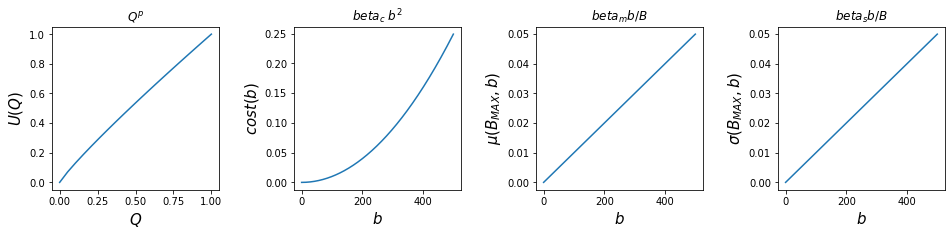

In [11]:
viz_main_functions(BMAX, NQ)

### 2.3. Experimentations

coord=(1, 15)	, v=1.23, vneigh=(0.87,0.84,0.819)	, b=499	, A_hat[ind_max]=-0.0	, n_iter=2	, n_expl=1
coord=(1, 14)	, v=1.96, vneigh=(0.84,0.82,0.826)	, b=499	, A_hat[ind_max]=0.0	, n_iter=2	, n_expl=2
coord=(1, 12)	, v=8.82, vneigh=(0.83,0.75,0.811)	, b=499	, A_hat[ind_max]=0.0	, n_iter=2	, n_expl=3
coord=(1, 10)	, v=6.79, vneigh=(0.81,0.66,0.608)	, b=499	, A_hat[ind_max]=0.0	, n_iter=2	, n_expl=4
coord=(1, 9)	, v=1.01, vneigh=(0.66,0.61,0.562)	, b=499	, A_hat[ind_max]=0.0	, n_iter=2	, n_expl=5


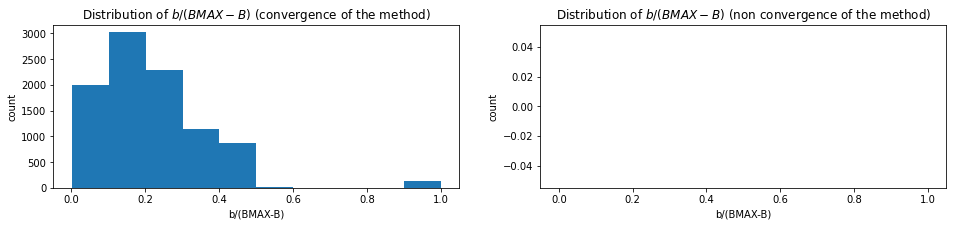

In [12]:
b_optimal, b_optimal_over_B, V, keep_i, keep_j = optimal_batch(dQ_step, dB_step, BMAX,
                                               print_res = False,
                                               print_steps = True,
                                               plot_distrib = True,
                                               eps = 0.0001,
                                               n_iterations = 10,
                                               n_explosions = 10,
                                               betac = BETAC,#5*10**(-7),
                                               betam = BETAM,#0.5,
                                               betas = BETAS,#0.5,
                                               p = P)

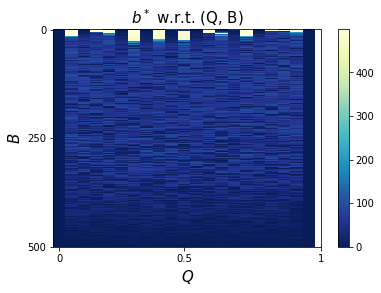

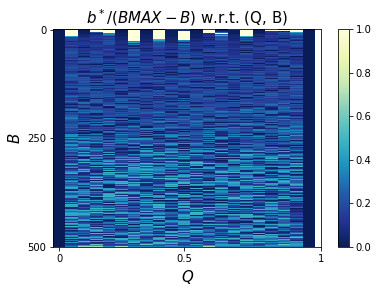

In [13]:
b_optimal_over_B1 = b_optimal_over_B.copy()
viz_heatmap(b_optimal, title="$b^*$");
viz_heatmap(b_optimal_over_B1, title="$b^*/(BMAX-B)$");

In [14]:
## SUPP ANALYSIS
#list(zip(V[:, 0].round(3), V[:, 1].round(3), V[:, -2].round(3), V[:, -1].round(3)))[-10:]
#print(V[-5:, :])

### 2.4. Tune hyper-parameters (visually)

#### 2.4.1. beta_c

In [15]:
betac = None

In [16]:
step = 2*10**(-6)
interval = step * np.arange(1, 4, 1)
interval

array([2.e-06, 4.e-06, 6.e-06])

In [17]:
## OLD
para_name = "betac"
p = 0.7
#betac = BETAC
betam = BETAM
betas = BETAS
#step = 5*10**(-7)
#interval = step * np.arange(1, 10, 3)
#step = 10**(-6)
#interval = step * np.arange(1, 6, 2)
step = 2*10**(-6)
interval = step * np.arange(1, 4, 1)
interval

optimal_by_cost = dict()
optimal_by_cost["interval"] = interval
optimal_by_cost["param_name"] = para_name
optimal_by_cost["values"] = dict()
optimal_by_cost["values"]["b*"] = []
optimal_by_cost["values"]["b*/(BMAX-B)"] = []
#optimal_by_cost["values"]["V"] = []

for i, beta in enumerate(interval):
    b_optimal, b_optimal_over_B, V, keep_i, keep_j = optimal_batch(dQ_step, dB_step, BMAX,
                                               print_res = False,
                                               print_steps = False,
                                               plot_distrib = False,
                                               eps = 0.0001,
                                               n_iterations = 10,
                                               n_explosions = 15,
                                                  betac = beta,
                                                  betam = betam,
                                                  betas = betas,
                                                  p=p)
    optimal_by_cost["values"]["b*"].append(b_optimal)
    optimal_by_cost["values"]["b*/(BMAX-B)"].append(b_optimal_over_B)
    #optimal_by_cost["values"]["V"].append(V)

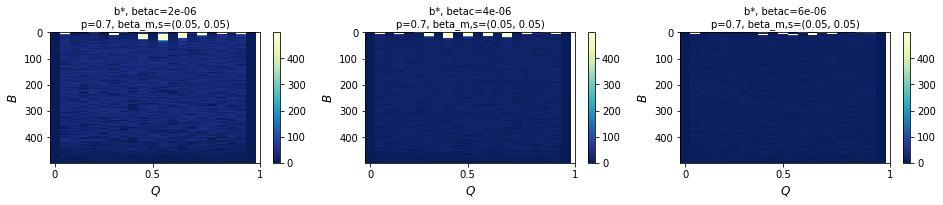

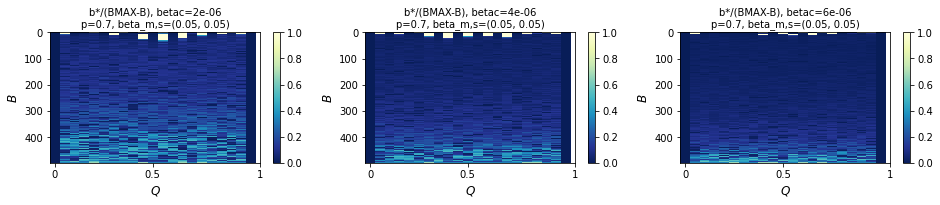

In [18]:
heatmap_by_param(optimal_by_cost, betac=betac, betam=betam, betas=betas, p=p)

#### 2.4.2. beta_m

In [19]:
## OLD
para_name = "betam"
p = 0.7
betac = BETAC
#betam = BETAM
betas = BETAS
step = 0.01
interval = step * np.arange(1, 6, 2) #step * np.arange(1, 10, 3) # step * np.arange(1, 10, 2)

optimal_by_cost = dict()
optimal_by_cost["interval"] = interval
optimal_by_cost["param_name"] = para_name
optimal_by_cost["values"] = dict()
optimal_by_cost["values"]["b*"] = []
optimal_by_cost["values"]["b*/(BMAX-B)"] = []
#optimal_by_cost["values"]["V"] = []

for i, beta in enumerate(interval):
    b_optimal, b_optimal_over_B, V, keep_i, keep_j = optimal_batch(dQ_step, dB_step, BMAX,
                                               print_res = False,
                                               print_steps = False,
                                               plot_distrib = False,
                                               eps = 0.0001,
                                               n_iterations = 10,
                                               n_explosions = 15,
                                                  betac = betac,
                                                  betam = beta,
                                                  betas = betas,
                                                  p=p)
    optimal_by_cost["values"]["b*"].append(b_optimal)
    optimal_by_cost["values"]["b*/(BMAX-B)"].append(b_optimal_over_B)
    #optimal_by_cost["values"]["V"].append(V)

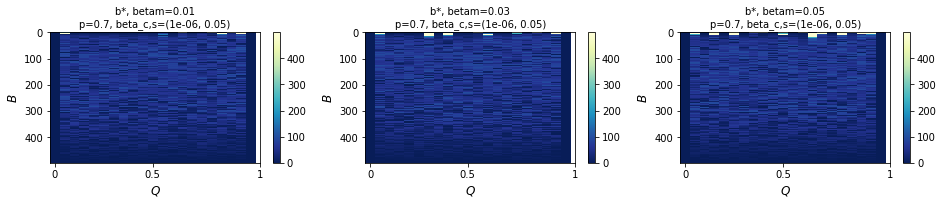

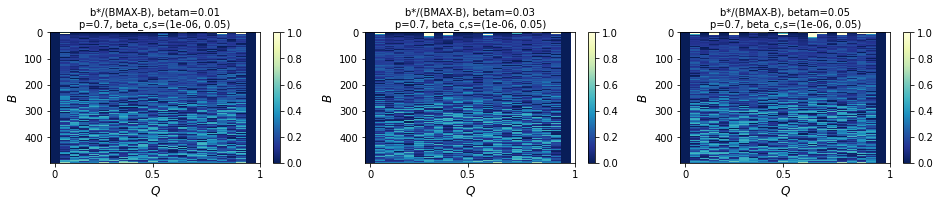

In [20]:
heatmap_by_param(optimal_by_cost, betac=betac, betam=betam, betas=betas, p=p)

#### 2.4.3. beta_s

In [21]:
## OLD
para_name = "betas"
p = 0.7
betac = BETAC
betam = BETAM
#betas = BETAS
step = 0.005
interval = step * np.arange(1, 15, 5)#np.arange(1, 10, 3)

optimal_by_cost = dict()
optimal_by_cost["interval"] = interval
optimal_by_cost["param_name"] = para_name #MODIFY
optimal_by_cost["values"] = dict()
optimal_by_cost["values"]["b*"] = []
optimal_by_cost["values"]["b*/(BMAX-B)"] = []
#optimal_by_cost["values"]["V"] = []

for i, beta in enumerate(interval):
    b_optimal, b_optimal_over_B, V, keep_i, keep_j = optimal_batch(dQ_step, dB_step, BMAX,
                                               print_res = False,
                                               print_steps = False,
                                               plot_distrib = False,
                                               eps = 0.0001,
                                               n_iterations = 10,
                                               n_explosions = 15,
                                                  betac = betac,
                                                  betam = beta,
                                                  betas = betas,
                                                  p=p)
    optimal_by_cost["values"]["b*"].append(b_optimal)
    optimal_by_cost["values"]["b*/(BMAX-B)"].append(b_optimal_over_B)
    #optimal_by_cost["values"]["V"].append(V)

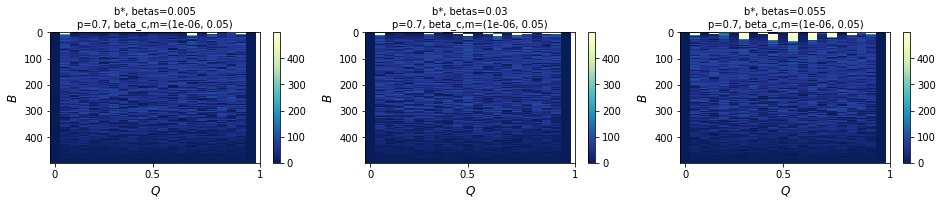

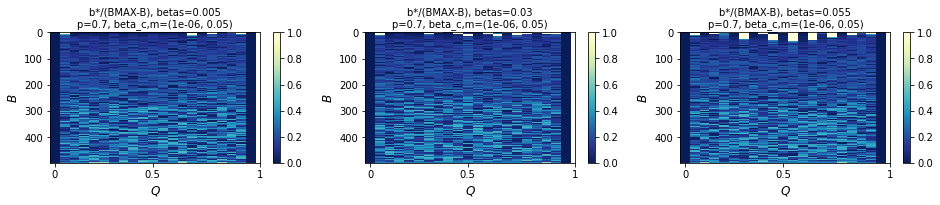

In [22]:
heatmap_by_param(optimal_by_cost, betac=betac, betam=betam, betas=betas, p=p)

#### 2.4.4. p

In [23]:
## OLD
#p = 0.99
betac = BETAC
betam = BETAM
betas = BETAS
step = 0.1
interval = step * np.arange(1, 10, 4)

optimal_by_cost = dict()
optimal_by_cost["interval"] = interval
optimal_by_cost["param_name"] = "p" #MODIFY
optimal_by_cost["values"] = dict()
optimal_by_cost["values"]["b*"] = []
optimal_by_cost["values"]["b*/(BMAX-B)"] = []
#optimal_by_cost["values"]["V"] = []

for i, p in enumerate(interval):
    b_optimal, b_optimal_over_B, V, keep_i, keep_j = optimal_batch(dQ_step, dB_step, BMAX,
                                               print_res = False,
                                               print_steps = False,
                                               plot_distrib = False,
                                               eps = 0.0001,
                                               n_iterations = 10,
                                               n_explosions = 15,
                                                  betac = betac,
                                                  betam = betam,
                                                  betas = betas,
                                                  p=p)
    optimal_by_cost["values"]["b*"].append(b_optimal)
    optimal_by_cost["values"]["b*/(BMAX-B)"].append(b_optimal_over_B)
    #optimal_by_cost["values"]["V"].append(V)

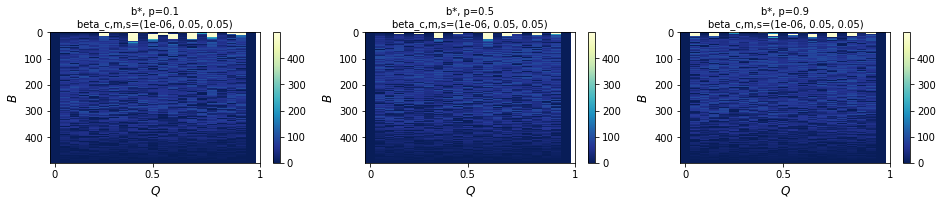

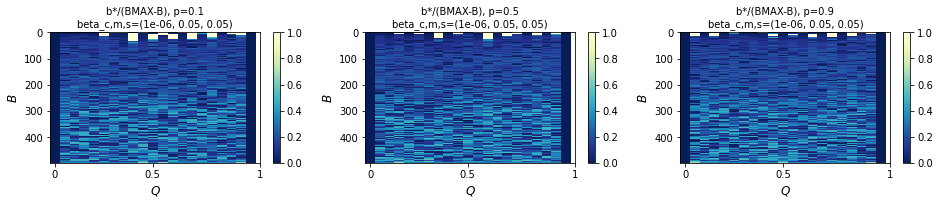

In [24]:
heatmap_by_param(optimal_by_cost, betac=betac, betam=betam, betas=betas, p=p)

#### 2.4.5. bw

In [25]:
#p = 0.99
betac = BETAC
betam = BETAM
betas = BETAS
bw = BW # NEW
interval = [0.1, 0.5, 1]

optimal_by_cost = dict()
optimal_by_cost["interval"] = interval
optimal_by_cost["param_name"] = "bw" #MODIFY
optimal_by_cost["values"] = dict()
optimal_by_cost["values"]["b*"] = []
optimal_by_cost["values"]["b*/(BMAX-B)"] = []
#optimal_by_cost["values"]["V"] = []

for i, bw in enumerate(interval):
    b_optimal, b_optimal_over_B, V, keep_i, keep_j = optimal_batch(dQ_step, dB_step, BMAX,
                                                                   print_res = False,
                                                                   print_steps = False,
                                                                   plot_distrib = False,
                                                                   eps = 0.0001,
                                                                   n_iterations = 10,
                                                                   n_explosions = 15,
                                                                   betac = betac,
                                                                   betam = betam,
                                                                   betas = betas,
                                                                   p = p,
                                                                   bw = bw)
    optimal_by_cost["values"]["b*"].append(b_optimal)
    optimal_by_cost["values"]["b*/(BMAX-B)"].append(b_optimal_over_B)
    #optimal_by_cost["values"]["V"].append(V)

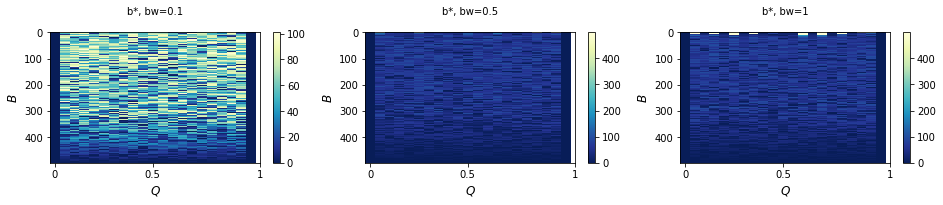

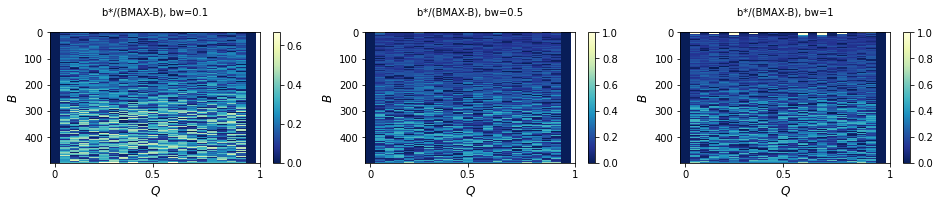

In [26]:
heatmap_by_param(optimal_by_cost, betac=betac, betam=betam, betas=betas, p=p)

Let us set:
- $p = 0.7$
- $\beta_c = 5\times 10^{-6}$
- $\beta_m = 0.05$
- $\beta_s = 0.05$
- $b_w = 2$

In [27]:
# TODO1: Analyze these results and deduce how we can use them in practice
# TODO2: Maybe analyze theoretically the convergence (and value explosion) issues ?
# TODO3: Put these results on Latex

## 3. Trajectories after calibration

In [28]:
def setup_ic(list_, ic_interval = False):
    """
    the input list should be a list of lists
    the input argument interval should be "ic" or "std"
    the output is the mean according to the axis 0 (cutted if not same size)
    """
    vmin = min([len(v) for v in list_])
    list_1 = [v[:vmin] for v in list_]
    if ic_interval:
        vic = 2*np.array(list_1).std(0)/len(list_1)
    else:
        vic = np.array(list_1).std(0)
    vmean = np.array(list_1).mean(0)
    return vmean, vic

def all_experimentation(BW=2, n=120, T=30, plot_distrib=True, plot_const_simu=True, plot_heatmap=True, plot_heatmap_traj=True):
    #####--- TESTING GROUND ---#####

    # OPTIMIZATION
    b_optimal, b_optimal_over_B, V, keep_i, keep_j = optimal_batch(
                                                    dQ_step,
                                                    dB_step,
                                                    BMAX,
                                                    print_res = False,
                                                    print_steps = True,
                                                    plot_distrib = plot_distrib,
                                                    eps = 0.0001,
                                                    n_iterations = 10,
                                                    n_explosions = 0,
                                                    n_print_coeffs = 0,#5,#100,
                                                    betac = BETAC,
                                                    betam = BETAM,
                                                    betas = BETAS,
                                                    p = P,
                                                    bw = BW)
    
    # PLOTTINGS
    plt.figure(figsize=(16, 8))
    n_simu = 20
    B0 = 1
    Q0 = 0.5
    bopts_list=[]
    Bopts_list=[]
    Qopts_list=[]
    Vopts_list=[]
    bconsts = [5, 20, 80] #2,

    plt.subplot(2, len(bconsts)+1, 1)
    for _ in range(n_simu):
        B, Q, bopts, boptstr_i, boptstr_j = stochastic_simulation(b_optimal, B0 = B0, n=n, T=T) # dt = T/n
        bopts_list.append(bopts)
        Bopts_list.append(B)
        Qopts_list.append(Q)
        Vopts_list.append(V[np.array(boptstr_i)-1, np.array(boptstr_j)-1])
        if len(B) == len(Q):
            plt.plot(B, Q, linestyle="-")
            plt.scatter(B, Q, marker="+")
        else:
            plt.plot(B[:min(len(B), len(Q))], Q[:min(len(B), len(Q))], linestyle="-")
            plt.scatter(B[:min(len(B), len(Q))], Q[:min(len(B), len(Q))], marker="+")
    plt.xlabel("B")
    plt.ylabel("Q")
    plt.title("Stochastic strategies")
    
    if plot_const_simu:
        for i, b0 in enumerate(bconsts, start=2):
            #print(i, b0)
            plt.subplot(2, len(bconsts)+1, i)
            for _ in range(n_simu):
                b_const = b0*np.ones(b_optimal.shape)
                B, Q, b, btr_i, btr_j = stochastic_simulation(b_const, B0=B0, Q0=Q0, n=n, T=T)
                if len(B) == len(Q):
                    plt.plot(B, Q, linestyle="-")
                    plt.scatter(B, Q, marker="+")
                else:
                    plt.plot(B[:min(len(B), len(Q))], Q[:min(len(B), len(Q))], linestyle="-")
                    plt.scatter(B[:min(len(B), len(Q))], Q[:min(len(B), len(Q))], marker="+")
            plt.xlabel("B")
            plt.ylabel("Q")
            plt.title(f"Deterministic strategies with b={b0}")
    else:
        i=1
        
    plt.subplot(2, len(bconsts)+1, i+1)
    for Q in Qopts_list:
        plt.plot(np.arange(len(Q)), Q)
    plt.xlabel("$t$", fontsize=15)
    plt.ylabel("$Q_t$", fontsize=15)
    plt.title("$Q_t$ w.r.t. $t$", fontsize=15)

    plt.subplot(2, len(bconsts)+1, i+2)
    for B in Bopts_list:
        plt.plot(np.arange(len(B)), B)
    for bconst in bconsts:
        B1 = np.arange(B0, BMAX+bconst, bconst)
        plt.plot(np.arange(len(B1)), B1, label=f"b={bconst}")
        plt.scatter(np.arange(len(B1)), B1, marker="+")

    plt.xlabel("$t$", fontsize=15)
    plt.ylabel("$B_t$", fontsize=15)
    plt.title("$B_t$ w.r.t. $t$", fontsize=15)
    plt.legend()

    plt.subplot(2, len(bconsts)+1, i+3)
    for bopts in bopts_list:
        plt.plot(np.arange(len(bopts)), bopts)
    plt.xlabel("$t$", fontsize=15)
    plt.ylabel("$b^*_t$", fontsize=15)
    plt.title("$b^*_t$ w.r.t. $t$", fontsize=15)
    plt.subplot(2, len(bconsts)+1, i+4)
    for vs in Vopts_list:
        plt.plot(np.arange(len(vs)), vs)
    plt.xlabel("$t$", fontsize=15)
    plt.ylabel("$V_t$", fontsize=15)
    plt.title("$V_t$ w.r.t. $t$", fontsize=15)
    plt.tight_layout();
    
    if plot_heatmap:
        if plot_heatmap_traj:
            btr_i=boptstr_i
            btr_j=boptstr_j
        else:
            btr_i = None
            btr_j = None
        #viz_heatmap(b_optimal, title="$b^*$")
        viz_heatmap(b_optimal_over_B, title="$b^*/(BMAX-B)$", btr_i=btr_i, btr_j=btr_j, BMAX=BMAX);
        #viz_heatmap(V, title="$V$", BMAX=BMAX);
    plt.show()

### 3.1. Calibration

In [29]:
BETAC

1e-06

In [30]:
from matplotlib.patches import Ellipse

np.random.seed(88)

#####--- TESTING GROUND ---#####

# GRID PARAMETERS
NQ   = 20         #Number of grid points
BMAX = 500        #Number of labeled points #BMAX = 500
dQ_step = 1/NQ    #Grid step
dB_step = 1       #Grid step

# FUNCTION PARAMETERS
BETAC = 5*10**(-6) #(1/BW)*10**(-6) #5*10**(-6) # 0.0005
BETAS = 0.005      #np.sqrt(1/BW)*0.005
BETAM = 0.05       #(1/BW)*0.05
P = 0.4

BW = 1
ALPHAC = 0 #0
D = 2

def U(Q, p=P):
    return (Q**p)

def sigma(B, b, betas=BETAS, bw=BW):
    return betas*(bw*b/(B+bw*b)) * (B+bw*b>0)

def mu(B, b, betam=BETAM, bw=BW):
    return betam*(bw*b/(B+bw*b)) * (B+bw*b>0)

def cost(b, betac=BETAC, d=D, alphac=ALPHAC):
    return alphac + betac * b**d

 =============== n, T = 100, 45 =============== 


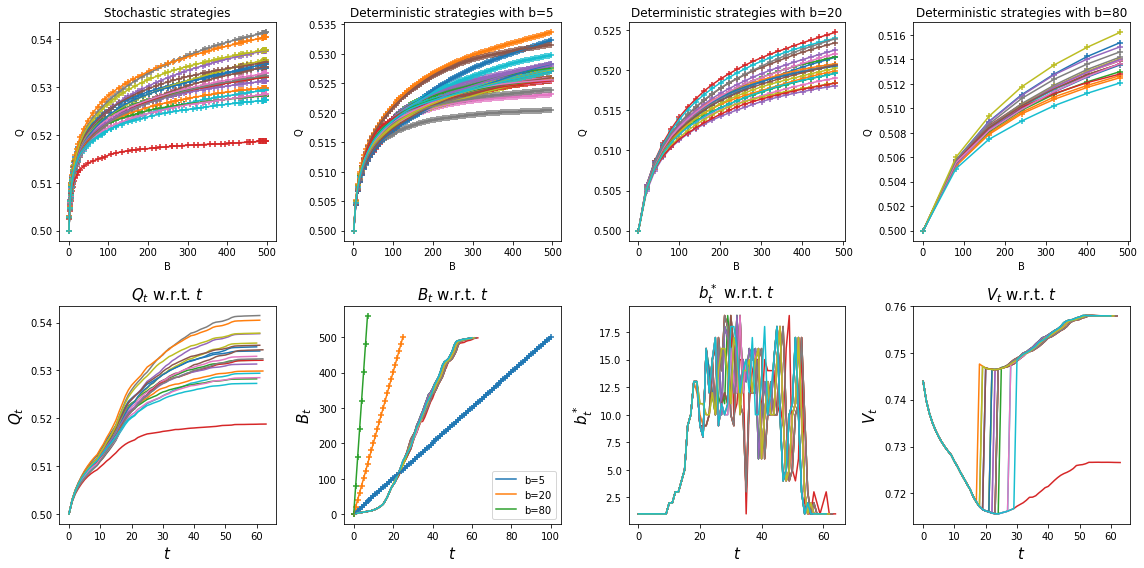

 =============== n, T = 100, 80 =============== 


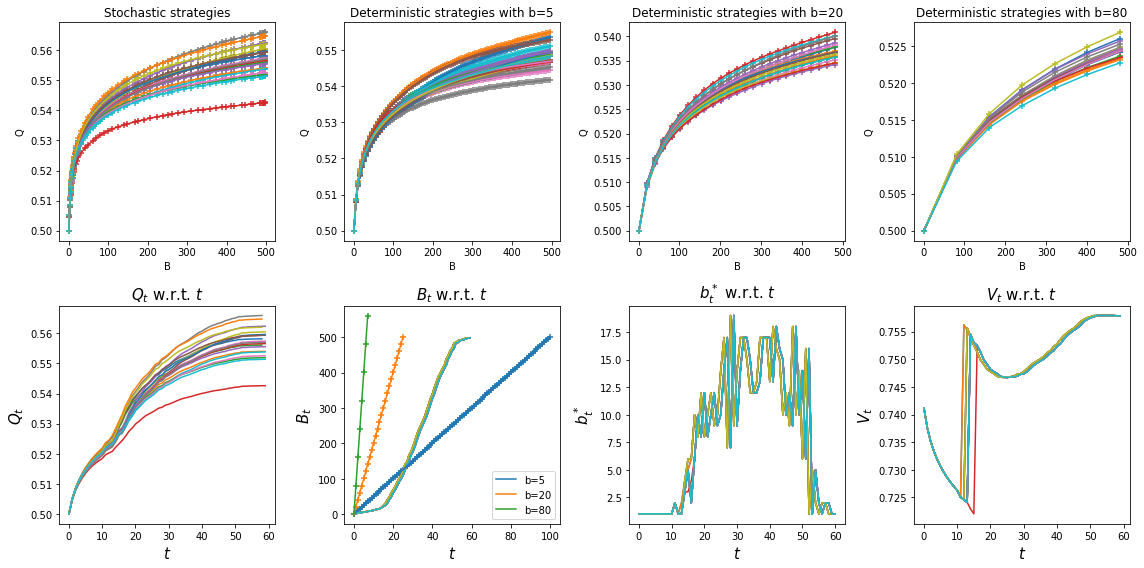

 =============== n, T = 100, 100 =============== 


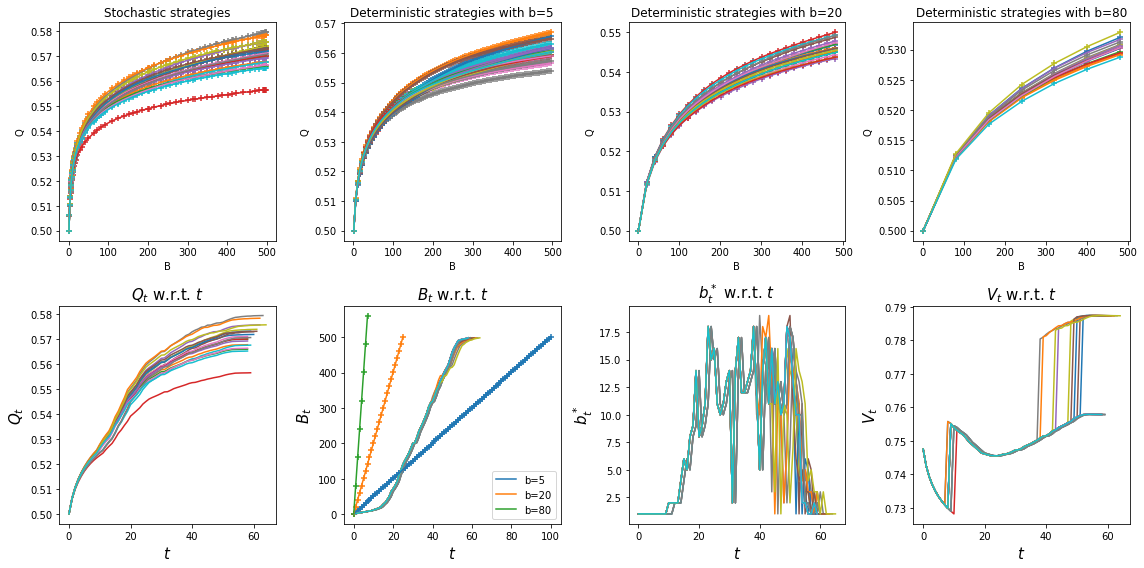

In [31]:
# (n, T) = (100, 40) if BMAX = 500
# (n, T) = (120, 80) if BMAX = 1000
n, T = 100, 40
B0, Q0 = 1, 0.5

BETAS = 0.005      #np.sqrt(1/BW)*0.005
BETAM = 0.05       #(1/BW)*0.05
BW = 1

for n in [100]: # 50, 50 ou 40, 60 ou 60, 60
    for T in [45, 80, 100]:
        print(f" =============== n, T = {n}, {T} =============== ")
        np.random.seed(88)
        all_experimentation(BW=BW,
                            T=T,
                            n=n,
                            plot_distrib=False,
                            plot_const_simu=True,
                            plot_heatmap=False,
                            plot_heatmap_traj=False)
    # dt = T/n
    # dWt 

### 3.2. Simulations

In [32]:
from matplotlib.patches import Ellipse

np.random.seed(88)

BW=1
# (n, T) = (100, 40) if BMAX = 500
# (n, T) = (120, 80) if BMAX = 1000
# NEW TEST (n, T) = (100, 80) if BMAX = 500
n, T = 100, 45
B0 = 1
Q0 = 0.5

plot_distrib=False
plot_const_simu=True
plot_heatmap=True
plot_heatmap_traj=False

# OPTIMIZATION
b_optimal, b_optimal_over_B, V, keep_i, keep_j = optimal_batch(
                                               dQ_step,
                                               dB_step,
                                               BMAX,
                                               print_res = False,
                                               print_steps = True,
                                               plot_distrib = plot_distrib,
                                               eps = 0.0001,
                                               n_iterations = 10,
                                               n_explosions = 0,
                                               n_print_coeffs = 0,#5,#100,
                                               betac = BETAC,
                                               betam = BETAM,
                                               betas = BETAS,
                                               p = P,
                                               bw = BW)

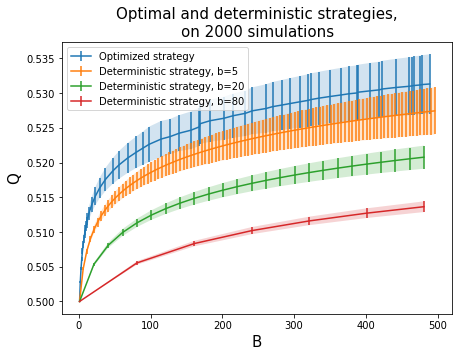

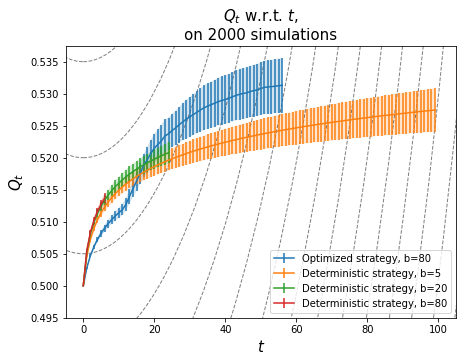

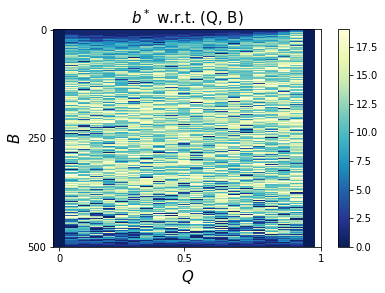

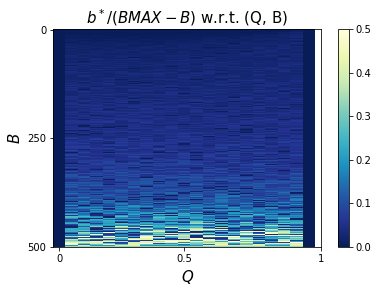

In [33]:
n_simu = 2000

# PLOTTINGS
plt.figure(figsize=(7, 5))

bopts_list=[]
Bopts_list=[]
Qopts_list=[]
Vopts_list=[]
bconsts = [5, 20, 80] #[5, 20, 80]

#plt.subplot(1, 2, 1)
for _ in range(n_simu):
    B, Q, bopts, boptstr_i, boptstr_j = stochastic_simulation(b_optimal, B0 = B0, n=n, T=T) # dt = T/n
    bopts_list.append(bopts)
    Bopts_list.append(B)
    Qopts_list.append(Q)
    Vopts_list.append(V[np.array(boptstr_i)-1, np.array(boptstr_j)-1])
Qmean, Qic = setup_ic(Qopts_list)
plt.fill_between(B[:len(Qmean)], (Qmean-Qic), (Qmean+Qic), alpha=.2)
plt.errorbar(B[:len(Qmean)], Qmean, yerr=Qic, label="Optimized strategy")

Q_const_dict = dict()
V_const_dict = dict()
if plot_const_simu:
    for i, b0 in enumerate(bconsts, start=2):
        Q_const_dict[b0] = dict()
        V_const_dict[b0] = dict()
        B_inter = []
        Q_inter = []
        V_inter = []
        for _ in range(n_simu):
            b_const = b0*np.ones(b_optimal.shape)
            B, Q, b, btr_i, btr_j = stochastic_simulation(b_const, B0=B0, Q0=Q0, n=n, T=T)
            B_inter.append(B)
            Q_inter.append(Q)
            V_inter.append(V[np.array(btr_i)-1, np.array(btr_j)-1])
        Qmean, Qic = setup_ic(Q_inter)
        plt.fill_between(B[:len(Qmean)], (Qmean-Qic), (Qmean+Qic), alpha=.2)
        plt.errorbar(B[:len(Qmean)], Qmean, yerr=Qic, label=f"Deterministic strategy, b={b0}")
        Q_const_dict[b0]["mean"] = np.array(Qmean)
        Q_const_dict[b0]["ic"] = np.array(Qic)
        
        Vmean, Vic = setup_ic(V_inter)
        V_const_dict[b0]["mean"] = Vmean
        V_const_dict[b0]["ic"]  = Vic
else:
    i=1
plt.xlabel("B", fontsize=15)
plt.ylabel("Q", fontsize=15)
plt.title(f"Optimal and deterministic strategies,\non {n_simu} simulations", fontsize=15)
plt.legend()
plt.show()

plt.figure(figsize=(7, 5))
#plt.subplot(1, 2, 2)
Qmean, Qic = setup_ic(Qopts_list)
#plt.plot(np.arange(len(Qmean)), Qmean, "-+", label=f"Optimized strategy", lw=2, markersize=7)
plt.fill_between(np.arange(len(Qmean)), (Qmean-Qic), (Qmean+Qic), alpha=.2)
plt.errorbar(np.arange(len(Qmean)), Qmean, yerr=Qic, label=f"Optimized strategy, b={b0}")
xmax = []
ymin = []
ymax = []
for i, b0 in enumerate(bconsts, start=2):
    Qic = Q_const_dict[b0]["ic"]
    Qmean = Q_const_dict[b0]["mean"]
    plt.fill_between(np.arange(len(Qmean)), (Qmean-Qic), (Qmean+Qic), alpha=.2)
    plt.errorbar(np.arange(len(Qmean)), Qmean, yerr=Qic, label=f"Deterministic strategy, b={b0}")
    #plt.plot(np.arange(len(Qmean)), Qmean, "-+", label=f"Deterministic strategy, b={b0}", lw=2, markersize=7)
    xmax.append(len(Qmean))
    ymax.append(max(Qmean))
    ymin.append(min(Qmean))
    
for r in np.arange(0.1, 5, 0.1):
    ax = plt.gca()
    ax.add_patch(Ellipse((0, 0.7), width=100*r, height=0.3*r, linestyle = "--", color='black', fill=False, alpha=.5))
plt.xlim([-5,max(xmax)+5])
plt.ylim([min(ymin)-0.005,max(ymax)+0.01])

plt.xlabel("$t$", fontsize=15)
plt.ylabel("$Q_t$", fontsize=15)
plt.title(f"$Q_t$ w.r.t. $t$,\non {n_simu} simulations", fontsize=15)
plt.legend()

#plt.tight_layout();
plt.show()

if plot_heatmap:
    if plot_heatmap_traj:
        btr_i=boptstr_i
        btr_j=boptstr_j
    else:
        btr_i = None
        btr_j = None
    viz_heatmap(b_optimal, title="$b^*$")
    viz_heatmap(b_optimal_over_B, title="$b^*/(BMAX-B)$", btr_i=btr_i, btr_j=btr_j, BMAX=BMAX);
    #viz_heatmap(V, title="$V$", BMAX=BMAX);

plt.show()

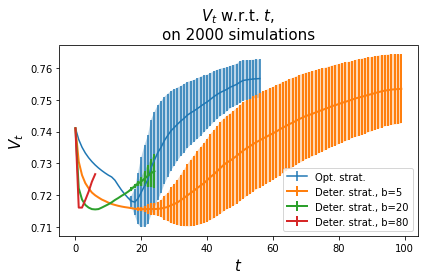

In [34]:
#plt.subplot(1, 2, 3)
#plt.subplot(2, len(bconsts)+1, i+2)
#for vs in Vopts_list:
#    plt.plot(np.arange(len(vs)), vs)
vmean, vic = setup_ic(Vopts_list, ic_interval = False)
plt.fill_between(np.arange(len(vmean)), (vmean-vic), (vmean+vic), alpha=.3)
plt.errorbar(np.arange(len(vmean)), vmean, yerr=vic, label=f"Opt. strat.")
xmax = []
ymin = []
ymax = []
for i, b0 in enumerate(bconsts, start=2):
    Vic = V_const_dict[b0]["ic"]
    Vmean = V_const_dict[b0]["mean"]
    #plt.fill_between(np.arange(len(Vmean)), (Vmean-Vstd), (Vmean+Vstd), alpha=.1)
    #plt.errorbar(np.arange(len(Vmean)), Vmean, yerr=Vstd, label=f"Deter. proc., b={b0}")
    plt.errorbar(np.arange(len(Vmean)), Vmean, yerr=Vic, label=f"Deter. strat., b={b0}", lw=2, markersize=7)
    plt.fill_between(np.arange(len(Vmean)), (Vmean-Vic), (Vmean+Vic), alpha=.3)
    xmax.append(len(Vmean))
    ymax.append(max(Vmean))
    ymin.append(min(Vmean))
#for r in np.arange(0.1, 5, 0.1):
#    ax = plt.gca()
#    ax.add_patch(Ellipse((0, 0.9), width=100*r, height=0.3*r, linestyle = "--", color='black', fill=False, alpha=.5))
#plt.xlim([-5,max(xmax)+5])
#plt.ylim([min(ymin)-0.01,max(ymax)+0.02])    
plt.xlabel("$t$", fontsize=15)
plt.ylabel("$V_t$", fontsize=15)
plt.title(f"$V_t$ w.r.t. $t$,\non {n_simu} simulations", fontsize=15)
plt.legend()

plt.tight_layout();
plt.show()
# sto : stratégie optimisée
# det : stratégie deter
# t -> bt
# peu de var car *drift* l'emporte, Q cv : bruit l'emporte donc plus de var

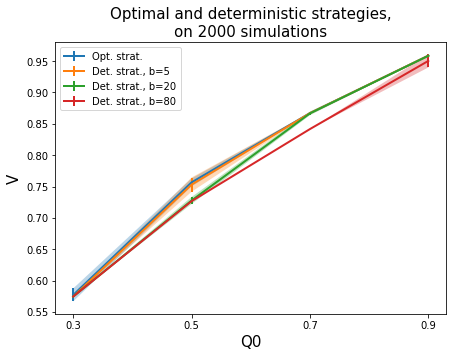

In [35]:
plt.figure(figsize=(7, 5))

bconsts = [5, 20, 80] #[5, 20, 80]
Q0s = [0.3, 0.5, 0.7, 0.9]
B0 = 1
nQ0 = len(Q0s)

V_dict = dict()
V_dict["opt"] = dict()
V_dict["opt"]["mean"] = np.zeros(nQ0)
V_dict["opt"]["ic"]  = np.zeros(nQ0)
for b0 in bconsts:
    V_dict[b0] = dict()
    V_dict[b0]["mean"] = np.zeros(nQ0)
    V_dict[b0]["ic"]  = np.zeros(nQ0)

for i, Q0 in enumerate(Q0s):
    Vopts_list = []
    for _ in range(n_simu):
        B, Q, bopts, boptstr_i, boptstr_j = stochastic_simulation(b_optimal, Q0=Q0, B0=B0, n=n, T=T) # dt = T/n
        Vopts_list.append(V[np.array(boptstr_i)-1, np.array(boptstr_j)-1])
    Vmean, Vic = setup_ic(Vopts_list)
    V_dict["opt"]["mean"][i] = Vmean[-1]
    V_dict["opt"]["ic"][i] = Vic[-1]
    
    for b0 in bconsts:
        V_inter = []
        for _ in range(n_simu):
            b_const = b0 * np.ones(b_optimal.shape)
            B, Q, b, btr_i, btr_j = stochastic_simulation(b_const, B0=B0, Q0=Q0, n=n, T=T)
            V_inter.append(V[np.array(btr_i)-1, np.array(btr_j)-1])
        Vmean, Vic = setup_ic(V_inter)
        V_dict[b0]["mean"][i] = Vmean[-1]
        V_dict[b0]["ic"][i] = Vic[-1]
        #print(f"QO = {Q0}, b0 = {b0}")
        #print(V_dict[b0]["mean"][i])
        #print()

plt.errorbar(Q0s, V_dict["opt"]["mean"], yerr=V_dict["opt"]["ic"], label=f"Opt. strat.", lw=2, markersize=7)
plt.fill_between(Q0s, (V_dict["opt"]["mean"]-V_dict["opt"]["ic"]), (V_dict["opt"]["mean"]+V_dict["opt"]["ic"]), alpha=.3)
for b0 in bconsts:
    plt.errorbar(Q0s, V_dict[b0]["mean"], yerr=V_dict[b0]["ic"], label=f"Det. strat., b={b0}", lw=2, markersize=7)
    plt.fill_between(Q0s, (V_dict[b0]["mean"]-V_dict[b0]["ic"]), (V_dict[b0]["mean"]+V_dict[b0]["ic"]), alpha=.3)

plt.xlabel("Q0", fontsize=15)
plt.xticks(Q0s)
plt.ylabel("V", fontsize=15)
plt.title(f"Optimal and deterministic strategies,\non {n_simu} simulations", fontsize=15)
plt.legend()
plt.show()

In [36]:
for i, Q0 in enumerate(Q0s):
    print(f"------------------ On {n_simu} simulations, Q0={Q0} ------------------")
    print(f'\tV_optimum =\t {round(V_dict["opt"]["mean"][i], 3)}+-{round(V_dict["opt"]["ic"][i], 3)}')
    for b0 in bconsts:
        print(f'\tV_const{b0} =\t {round(V_dict[b0]["mean"][i], 3)}+-{round(V_dict[b0]["ic"][i], 3)}')
    print()

------------------ On 2000 simulations, Q0=0.3 ------------------
	V_optimum =	 0.577+-0.01
	V_const5 =	 0.574+-0.001
	V_const20 =	 0.574+-0.0
	V_const80 =	 0.574+-0.0

------------------ On 2000 simulations, Q0=0.5 ------------------
	V_optimum =	 0.757+-0.006
	V_const5 =	 0.753+-0.011
	V_const20 =	 0.728+-0.006
	V_const80 =	 0.727+-0.0

------------------ On 2000 simulations, Q0=0.7 ------------------
	V_optimum =	 0.867+-0.001
	V_const5 =	 0.867+-0.001
	V_const20 =	 0.867+-0.003
	V_const80 =	 0.842+-0.0

------------------ On 2000 simulations, Q0=0.9 ------------------
	V_optimum =	 0.959+-0.0
	V_const5 =	 0.959+-0.0
	V_const20 =	 0.959+-0.0
	V_const80 =	 0.95+-0.01



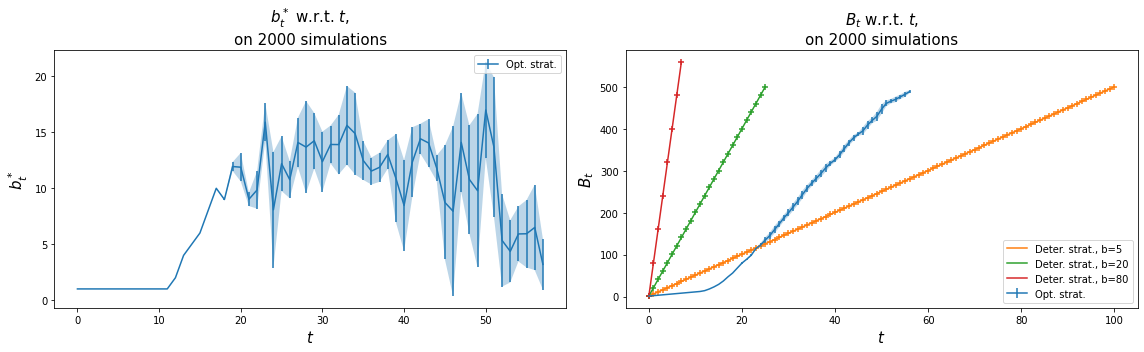

In [37]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
#for bopts in bopts_list:
#    plt.plot(np.arange(len(bopts)), bopts)
bmin = min([len(bopts) for bopts in bopts_list])
bopts_list1 = [bopts[:bmin] for bopts in bopts_list]
bstd = np.array(bopts_list1).std(0)
bmean = np.array(bopts_list1).mean(0)
plt.fill_between(np.arange(len(bmean)), (bmean-bstd), (bmean+bstd), alpha=.3)
plt.errorbar(np.arange(len(bmean)), bmean, yerr=bstd, label=f"Opt. strat.")
#for bconst in bconsts:
#    B1 = np.arange(B0, BMAX+bconst, bconst)
#    plt.plot(np.arange(len(B1)), np.ones(len(B1))*bconst, label=f"Deter. proc., b={bconst}")
#    #plt.scatter(np.arange(len(B1)), bconst, marker="+")
plt.xlabel("$t$", fontsize=15)
plt.ylabel("$b^*_t$", fontsize=15)
plt.title(f"$b^*_t$ w.r.t. $t$,\non {n_simu} simulations", fontsize=15)
plt.legend()

plt.subplot(1, 2, 2)
Bmin = min([len(B) for B in Bopts_list])
Bopts_list1 = [B[:Bmin] for B in Bopts_list]
Bstd = np.array(Bopts_list1).std(0)
Bmean = np.array(Bopts_list1).mean(0)
plt.fill_between(np.arange(len(Bmean)), (Bmean-Bstd), (Bmean+Bstd), alpha=.3)
plt.errorbar(np.arange(len(Bmean)), Bmean, yerr=Bstd, label=f"Opt. strat.")
for bconst in bconsts:
    B1 = np.arange(B0, BMAX+bconst, bconst)
    plt.plot(np.arange(len(B1)), B1, label=f"Deter. strat., b={bconst}")
    plt.scatter(np.arange(len(B1)), B1, marker="+")
plt.xlabel("$t$", fontsize=15)
plt.ylabel("$B_t$", fontsize=15)
plt.title(f"$B_t$ w.r.t. $t$,\non {n_simu} simulations", fontsize=15)
plt.legend()

plt.tight_layout();

## ADDITIONAL RESULTS

In [38]:
from matplotlib.patches import Ellipse

# GRID PARAMETERS
NQ   = 20         #Number of grid points
BMAX = 1000        #Number of labeled points #BMAX = 500
dQ_step = 1/NQ    #Grid step
dB_step = 1       #Grid step

# FUNCTION PARAMETERS
BETAC = 5*10**(-6) #(1/BW)*10**(-6) #5*10**(-6) # 0.0005
BETAS = 0.005      #np.sqrt(1/BW)*0.005
BETAM = 0.05       #(1/BW)*0.05
P = 0.4

BW = 1
ALPHAC = 0 #0
D = 2

np.random.seed(88)

BW=1
# (n, T) = (100, 45) if BMAX = 500
# (n, T) = (200, 60) if BMAX = 1000
n, T = 200, 60
B0 = 1
Q0 = 0.5

plot_distrib=False
plot_const_simu=True
plot_heatmap=True
plot_heatmap_traj=False

# OPTIMIZATION
b_optimal, b_optimal_over_B, V, keep_i, keep_j = optimal_batch(
                                               dQ_step,
                                               dB_step,
                                               BMAX,
                                               print_res = False,
                                               print_steps = True,
                                               plot_distrib = plot_distrib,
                                               eps = 0.0001,
                                               n_iterations = 10,
                                               n_explosions = 0,
                                               n_print_coeffs = 0,#5,#100,
                                               betac = BETAC,
                                               betam = BETAM,
                                               betas = BETAS,
                                               p = P,
                                               bw = BW)

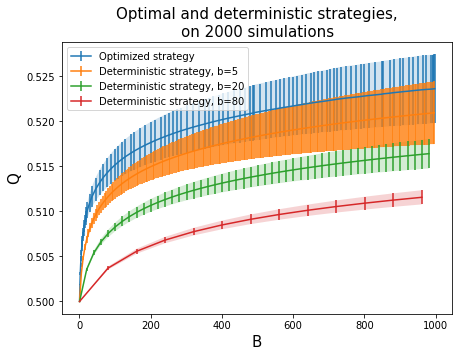

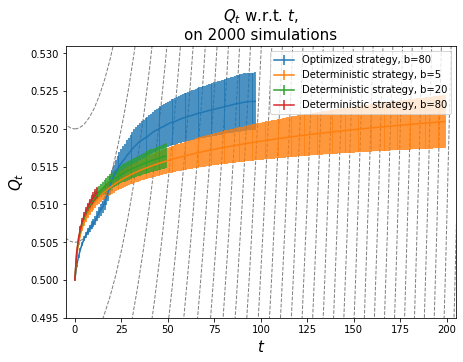

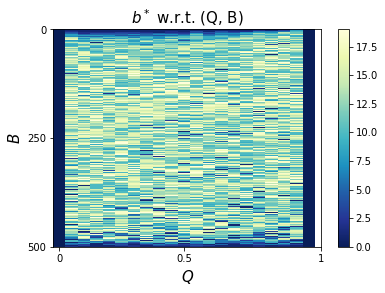

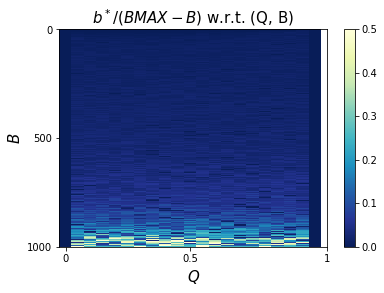

In [39]:
# PLOTTINGS
plt.figure(figsize=(7, 5))

bopts_list=[]
Bopts_list=[]
Qopts_list=[]
Vopts_list=[]
bconsts = [5, 20, 80] #[5, 20, 80]

#plt.subplot(1, 2, 1)
for _ in range(n_simu):
    B, Q, bopts, boptstr_i, boptstr_j = stochastic_simulation(b_optimal, B0 = B0, n=n, T=T) # dt = T/n
    bopts_list.append(bopts)
    Bopts_list.append(B)
    Qopts_list.append(Q)
    Vopts_list.append(V[np.array(boptstr_i)-1, np.array(boptstr_j)-1])
Qmean, Qic = setup_ic(Qopts_list)
plt.fill_between(B[:len(Qmean)], (Qmean-Qic), (Qmean+Qic), alpha=.2)
plt.errorbar(B[:len(Qmean)], Qmean, yerr=Qic, label="Optimized strategy")

Q_const_dict = dict()
V_const_dict = dict()
if plot_const_simu:
    for i, b0 in enumerate(bconsts, start=2):
        Q_const_dict[b0] = dict()
        V_const_dict[b0] = dict()
        B_inter = []
        Q_inter = []
        V_inter = []
        for _ in range(n_simu):
            b_const = b0*np.ones(b_optimal.shape)
            B, Q, b, btr_i, btr_j = stochastic_simulation(b_const, B0=B0, Q0=Q0, n=n, T=T)
            B_inter.append(B)
            Q_inter.append(Q)
            V_inter.append(V[np.array(btr_i)-1, np.array(btr_j)-1])
        Qmean, Qic = setup_ic(Q_inter)
        plt.fill_between(B[:len(Qmean)], (Qmean-Qic), (Qmean+Qic), alpha=.2)
        plt.errorbar(B[:len(Qmean)], Qmean, yerr=Qic, label=f"Deterministic strategy, b={b0}")
        Q_const_dict[b0]["mean"] = np.array(Qmean)
        Q_const_dict[b0]["ic"] = np.array(Qic)
        
        Vmean, Vic = setup_ic(V_inter)
        V_const_dict[b0]["mean"] = Vmean
        V_const_dict[b0]["ic"]  = Vic
else:
    i=1
plt.xlabel("B", fontsize=15)
plt.ylabel("Q", fontsize=15)
plt.title(f"Optimal and deterministic strategies,\non {n_simu} simulations", fontsize=15)
plt.legend()
plt.show()

plt.figure(figsize=(7, 5))
#plt.subplot(1, 2, 2)
Qmean, Qic = setup_ic(Qopts_list)
#plt.plot(np.arange(len(Qmean)), Qmean, "-+", label=f"Optimized strategy", lw=2, markersize=7)
plt.fill_between(np.arange(len(Qmean)), (Qmean-Qic), (Qmean+Qic), alpha=.2)
plt.errorbar(np.arange(len(Qmean)), Qmean, yerr=Qic, label=f"Optimized strategy, b={b0}")
xmax = []
ymin = []
ymax = []
for i, b0 in enumerate(bconsts, start=2):
    Qic = Q_const_dict[b0]["ic"]
    Qmean = Q_const_dict[b0]["mean"]
    plt.fill_between(np.arange(len(Qmean)), (Qmean-Qic), (Qmean+Qic), alpha=.2)
    plt.errorbar(np.arange(len(Qmean)), Qmean, yerr=Qic, label=f"Deterministic strategy, b={b0}")
    #plt.plot(np.arange(len(Qmean)), Qmean, "-+", label=f"Deterministic strategy, b={b0}", lw=2, markersize=7)
    xmax.append(len(Qmean))
    ymax.append(max(Qmean))
    ymin.append(min(Qmean))
    
for r in np.arange(0.1, 5, 0.1):
    ax = plt.gca()
    ax.add_patch(Ellipse((0, 0.7), width=100*r, height=0.3*r, linestyle = "--", color='black', fill=False, alpha=.5))
plt.xlim([-5,max(xmax)+5])
plt.ylim([min(ymin)-0.005,max(ymax)+0.01])

plt.xlabel("$t$", fontsize=15)
plt.ylabel("$Q_t$", fontsize=15)
plt.title(f"$Q_t$ w.r.t. $t$,\non {n_simu} simulations", fontsize=15)
plt.legend()

#plt.tight_layout();
plt.show()

if plot_heatmap:
    if plot_heatmap_traj:
        btr_i=boptstr_i
        btr_j=boptstr_j
    else:
        btr_i = None
        btr_j = None
    viz_heatmap(b_optimal, title="$b^*$")
    viz_heatmap(b_optimal_over_B, title="$b^*/(BMAX-B)$", btr_i=btr_i, btr_j=btr_j, BMAX=BMAX);
    #viz_heatmap(V, title="$V$", BMAX=BMAX);

plt.show()

In [40]:
# REFLECHIR A FAIRE DES LIGNES DE NIVEAU V SELON (Q0, BMAX)

In [41]:
from matplotlib.patches import Ellipse

n_simu = 500

# GRID PARAMETERS
NQ   = 20         #Number of grid points
BMAX = 500        #Number of labeled points #BMAX = 500
dQ_step = 1/NQ    #Grid step
dB_step = 1       #Grid step

# FUNCTION PARAMETERS
BETAC = 5*10**(-6) #(1/BW)*10**(-6) #5*10**(-6) # 0.0005
BETAS = 0.005      #np.sqrt(1/BW)*0.005
BETAM = 0.05       #(1/BW)*0.05
P = 0.4

BW = 1
ALPHAC = 0 #0
D = 2

np.random.seed(88)

BW=1
# (n, T) = (100, 45) if BMAX = 500
# (n, T) = (200, 60) if BMAX = 1000
n, T = 100, 45
B0 = 1
Q0 = 0.3

plot_distrib=False
plot_const_simu=True
plot_heatmap=True
plot_heatmap_traj=False

# OPTIMIZATION
b_optimal, b_optimal_over_B, V, keep_i, keep_j = optimal_batch(
                                               dQ_step,
                                               dB_step,
                                               BMAX,
                                               print_res = False,
                                               print_steps = True,
                                               plot_distrib = plot_distrib,
                                               eps = 0.0001,
                                               n_iterations = 10,
                                               n_explosions = 0,
                                               n_print_coeffs = 0,#5,#100,
                                               betac = BETAC,
                                               betam = BETAM,
                                               betas = BETAS,
                                               p = P,
                                               bw = BW)

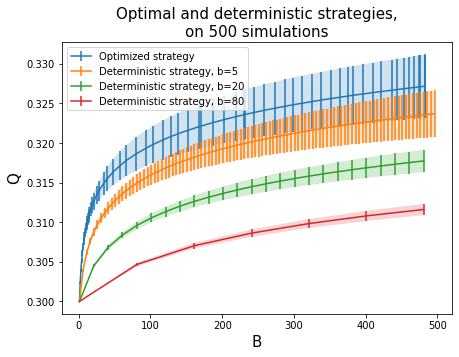

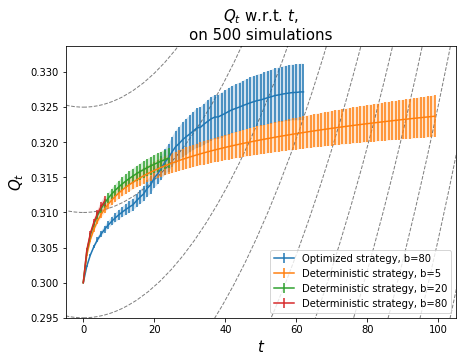

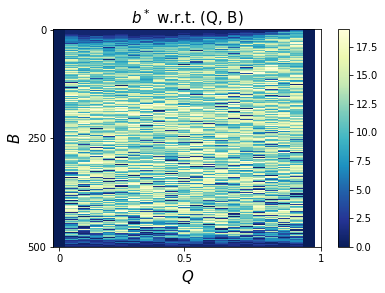

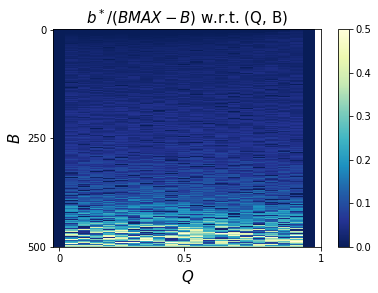

In [42]:
# PLOTTINGS
plt.figure(figsize=(7, 5))

bopts_list=[]
Bopts_list=[]
Qopts_list=[]
Vopts_list=[]
bconsts = [5, 20, 80] #[5, 20, 80]

#plt.subplot(1, 2, 1)
for _ in range(n_simu):
    B, Q, bopts, boptstr_i, boptstr_j = stochastic_simulation(b_optimal, B0=B0, Q0=Q0, n=n, T=T) # dt = T/n
    bopts_list.append(bopts)
    Bopts_list.append(B)
    Qopts_list.append(Q)
    Vopts_list.append(V[np.array(boptstr_i)-1, np.array(boptstr_j)-1])
Qmean, Qic = setup_ic(Qopts_list)
plt.fill_between(B[:len(Qmean)], (Qmean-Qic), (Qmean+Qic), alpha=.2)
plt.errorbar(B[:len(Qmean)], Qmean, yerr=Qic, label="Optimized strategy")

Q_const_dict = dict()
V_const_dict = dict()
if plot_const_simu:
    for i, b0 in enumerate(bconsts, start=2):
        Q_const_dict[b0] = dict()
        V_const_dict[b0] = dict()
        B_inter = []
        Q_inter = []
        V_inter = []
        for _ in range(n_simu):
            b_const = b0*np.ones(b_optimal.shape)
            B, Q, b, btr_i, btr_j = stochastic_simulation(b_const, B0=B0, Q0=Q0, n=n, T=T)
            B_inter.append(B)
            Q_inter.append(Q)
            V_inter.append(V[np.array(btr_i)-1, np.array(btr_j)-1])
        Qmean, Qic = setup_ic(Q_inter)
        plt.fill_between(B[:len(Qmean)], (Qmean-Qic), (Qmean+Qic), alpha=.2)
        plt.errorbar(B[:len(Qmean)], Qmean, yerr=Qic, label=f"Deterministic strategy, b={b0}")
        Q_const_dict[b0]["mean"] = np.array(Qmean)
        Q_const_dict[b0]["ic"] = np.array(Qic)
        
        Vmean, Vic = setup_ic(V_inter)
        V_const_dict[b0]["mean"] = Vmean
        V_const_dict[b0]["ic"]  = Vic
else:
    i=1
plt.xlabel("B", fontsize=15)
plt.ylabel("Q", fontsize=15)
plt.title(f"Optimal and deterministic strategies,\non {n_simu} simulations", fontsize=15)
plt.legend()
plt.show()

plt.figure(figsize=(7, 5))
#plt.subplot(1, 2, 2)
Qmean, Qic = setup_ic(Qopts_list)
#plt.plot(np.arange(len(Qmean)), Qmean, "-+", label=f"Optimized strategy", lw=2, markersize=7)
plt.fill_between(np.arange(len(Qmean)), (Qmean-Qic), (Qmean+Qic), alpha=.2)
plt.errorbar(np.arange(len(Qmean)), Qmean, yerr=Qic, label=f"Optimized strategy, b={b0}")
xmax = []
ymin = []
ymax = []
for i, b0 in enumerate(bconsts, start=2):
    Qic = Q_const_dict[b0]["ic"]
    Qmean = Q_const_dict[b0]["mean"]
    plt.fill_between(np.arange(len(Qmean)), (Qmean-Qic), (Qmean+Qic), alpha=.2)
    plt.errorbar(np.arange(len(Qmean)), Qmean, yerr=Qic, label=f"Deterministic strategy, b={b0}")
    #plt.plot(np.arange(len(Qmean)), Qmean, "-+", label=f"Deterministic strategy, b={b0}", lw=2, markersize=7)
    xmax.append(len(Qmean))
    ymax.append(max(Qmean))
    ymin.append(min(Qmean))
    
for r in np.arange(0.1, 5, 0.1):
    ax = plt.gca()
    ax.add_patch(Ellipse((0, 0.7), width=100*r, height=0.3*r, linestyle = "--", color='black', fill=False, alpha=.5))
plt.xlim([-5,max(xmax)+5])
plt.ylim([min(ymin)-0.005,max(ymax)+0.01])

plt.xlabel("$t$", fontsize=15)
plt.ylabel("$Q_t$", fontsize=15)
plt.title(f"$Q_t$ w.r.t. $t$,\non {n_simu} simulations", fontsize=15)
plt.legend()

#plt.tight_layout();
plt.show()

if plot_heatmap:
    if plot_heatmap_traj:
        btr_i=boptstr_i
        btr_j=boptstr_j
    else:
        btr_i = None
        btr_j = None
    viz_heatmap(b_optimal, title="$b^*$")
    viz_heatmap(b_optimal_over_B, title="$b^*/(BMAX-B)$", btr_i=btr_i, btr_j=btr_j, BMAX=BMAX);
    #viz_heatmap(V, title="$V$", BMAX=BMAX);

plt.show()

In [43]:
from matplotlib.patches import Ellipse

n_simu = 500

# GRID PARAMETERS
NQ   = 20         #Number of grid points
BMAX = 500        #Number of labeled points #BMAX = 500
dQ_step = 1/NQ    #Grid step
dB_step = 1       #Grid step

# FUNCTION PARAMETERS
BETAC = 5*10**(-6) #(1/BW)*10**(-6) #5*10**(-6) # 0.0005
BETAS = 0.005      #np.sqrt(1/BW)*0.005
BETAM = 0.05       #(1/BW)*0.05
P = 0.4

BW = 1
ALPHAC = 0 #0
D = 2

np.random.seed(88)

BW=1
# (n, T) = (100, 45) if BMAX = 500
# (n, T) = (200, 60) if BMAX = 1000
n, T = 100, 45
B0 = 1
Q0 = 0.9

plot_distrib=False
plot_const_simu=True
plot_heatmap=True
plot_heatmap_traj=False

# OPTIMIZATION
b_optimal, b_optimal_over_B, V, keep_i, keep_j = optimal_batch(
                                               dQ_step,
                                               dB_step,
                                               BMAX,
                                               print_res = False,
                                               print_steps = True,
                                               plot_distrib = plot_distrib,
                                               eps = 0.0001,
                                               n_iterations = 10,
                                               n_explosions = 0,
                                               n_print_coeffs = 0,#5,#100,
                                               betac = BETAC,
                                               betam = BETAM,
                                               betas = BETAS,
                                               p = P,
                                               bw = BW)

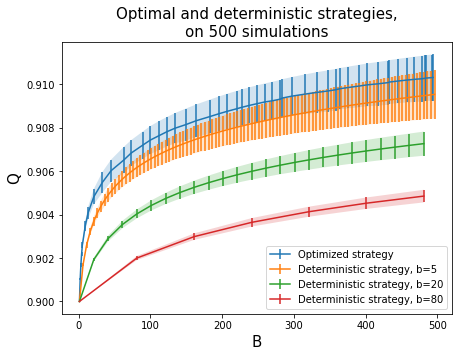

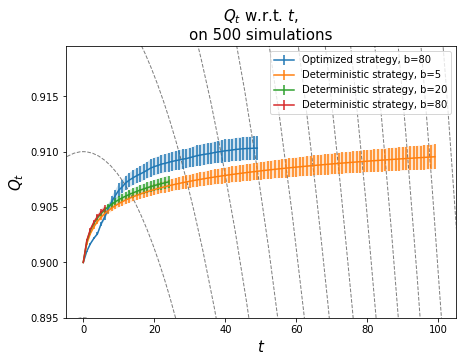

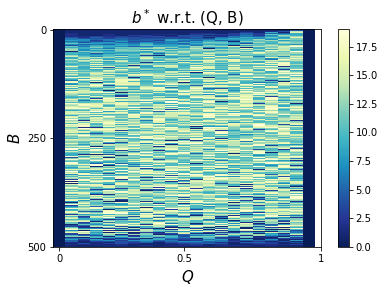

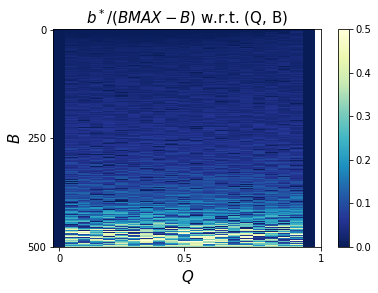

In [44]:
# PLOTTINGS
plt.figure(figsize=(7, 5))

bopts_list=[]
Bopts_list=[]
Qopts_list=[]
Vopts_list=[]
bconsts = [5, 20, 80] #[5, 20, 80]

#plt.subplot(1, 2, 1)
for _ in range(n_simu):
    B, Q, bopts, boptstr_i, boptstr_j = stochastic_simulation(b_optimal, B0=B0, Q0=Q0, n=n, T=T) # dt = T/n
    bopts_list.append(bopts)
    Bopts_list.append(B)
    Qopts_list.append(Q)
    Vopts_list.append(V[np.array(boptstr_i)-1, np.array(boptstr_j)-1])
Qmean, Qic = setup_ic(Qopts_list)
plt.fill_between(B[:len(Qmean)], (Qmean-Qic), (Qmean+Qic), alpha=.2)
plt.errorbar(B[:len(Qmean)], Qmean, yerr=Qic, label="Optimized strategy")

Q_const_dict = dict()
V_const_dict = dict()
if plot_const_simu:
    for i, b0 in enumerate(bconsts, start=2):
        Q_const_dict[b0] = dict()
        V_const_dict[b0] = dict()
        B_inter = []
        Q_inter = []
        V_inter = []
        for _ in range(n_simu):
            b_const = b0*np.ones(b_optimal.shape)
            B, Q, b, btr_i, btr_j = stochastic_simulation(b_const, B0=B0, Q0=Q0, n=n, T=T)
            B_inter.append(B)
            Q_inter.append(Q)
            V_inter.append(V[np.array(btr_i)-1, np.array(btr_j)-1])
        Qmean, Qic = setup_ic(Q_inter)
        plt.fill_between(B[:len(Qmean)], (Qmean-Qic), (Qmean+Qic), alpha=.2)
        plt.errorbar(B[:len(Qmean)], Qmean, yerr=Qic, label=f"Deterministic strategy, b={b0}")
        Q_const_dict[b0]["mean"] = np.array(Qmean)
        Q_const_dict[b0]["ic"] = np.array(Qic)
        
        Vmean, Vic = setup_ic(V_inter)
        V_const_dict[b0]["mean"] = Vmean
        V_const_dict[b0]["ic"]  = Vic
else:
    i=1
plt.xlabel("B", fontsize=15)
plt.ylabel("Q", fontsize=15)
plt.title(f"Optimal and deterministic strategies,\non {n_simu} simulations", fontsize=15)
plt.legend()
plt.show()

plt.figure(figsize=(7, 5))
#plt.subplot(1, 2, 2)
Qmean, Qic = setup_ic(Qopts_list)
#plt.plot(np.arange(len(Qmean)), Qmean, "-+", label=f"Optimized strategy", lw=2, markersize=7)
plt.fill_between(np.arange(len(Qmean)), (Qmean-Qic), (Qmean+Qic), alpha=.2)
plt.errorbar(np.arange(len(Qmean)), Qmean, yerr=Qic, label=f"Optimized strategy, b={b0}")
xmax = []
ymin = []
ymax = []
for i, b0 in enumerate(bconsts, start=2):
    Qic = Q_const_dict[b0]["ic"]
    Qmean = Q_const_dict[b0]["mean"]
    plt.fill_between(np.arange(len(Qmean)), (Qmean-Qic), (Qmean+Qic), alpha=.2)
    plt.errorbar(np.arange(len(Qmean)), Qmean, yerr=Qic, label=f"Deterministic strategy, b={b0}")
    #plt.plot(np.arange(len(Qmean)), Qmean, "-+", label=f"Deterministic strategy, b={b0}", lw=2, markersize=7)
    xmax.append(len(Qmean))
    ymax.append(max(Qmean))
    ymin.append(min(Qmean))
    
for r in np.arange(0.1, 5, 0.1):
    ax = plt.gca()
    ax.add_patch(Ellipse((0, 0.7), width=100*r, height=0.3*r, linestyle = "--", color='black', fill=False, alpha=.5))
plt.xlim([-5,max(xmax)+5])
plt.ylim([min(ymin)-0.005,max(ymax)+0.01])

plt.xlabel("$t$", fontsize=15)
plt.ylabel("$Q_t$", fontsize=15)
plt.title(f"$Q_t$ w.r.t. $t$,\non {n_simu} simulations", fontsize=15)
plt.legend()

#plt.tight_layout();
plt.show()

if plot_heatmap:
    if plot_heatmap_traj:
        btr_i=boptstr_i
        btr_j=boptstr_j
    else:
        btr_i = None
        btr_j = None
    viz_heatmap(b_optimal, title="$b^*$")
    viz_heatmap(b_optimal_over_B, title="$b^*/(BMAX-B)$", btr_i=btr_i, btr_j=btr_j, BMAX=BMAX);
    #viz_heatmap(V, title="$V$", BMAX=BMAX);

plt.show()

## BACKUP RESULTS

Let us set:
- $p = 0.3$
- $b_w = 1$
- $\beta_c = \frac{1}{b_w}10^{-6} = 10^{-6}$
- $\beta_m = \frac{1}{b_w}0.05 = 0.05$
- $\beta_s = \frac{1}{\sqrt{b_w}}0.005 = 0.005$

with $dt = T/n$, $T = 50, n = 120$

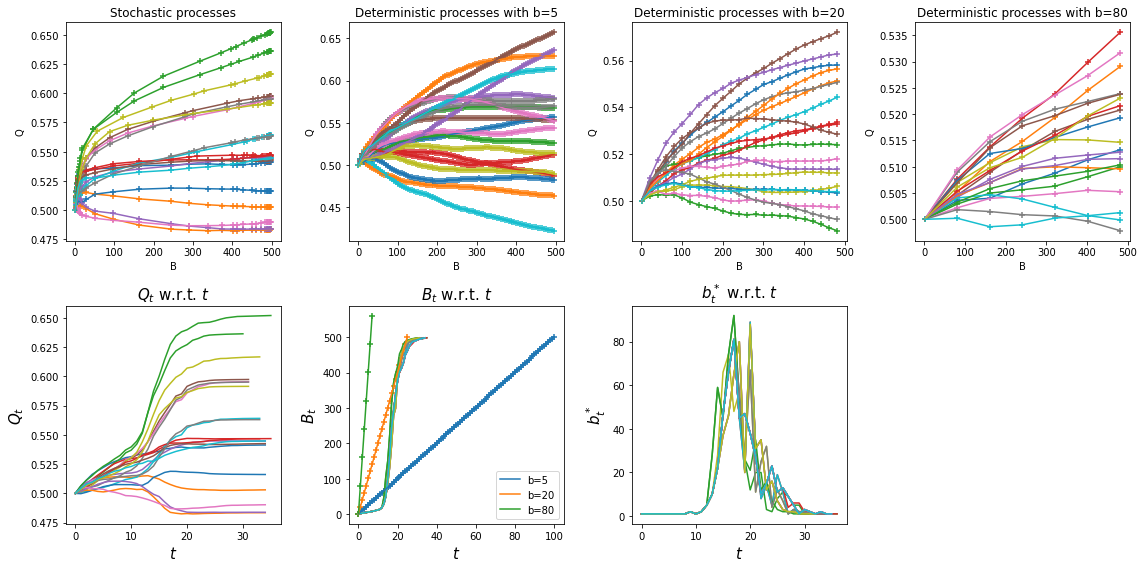

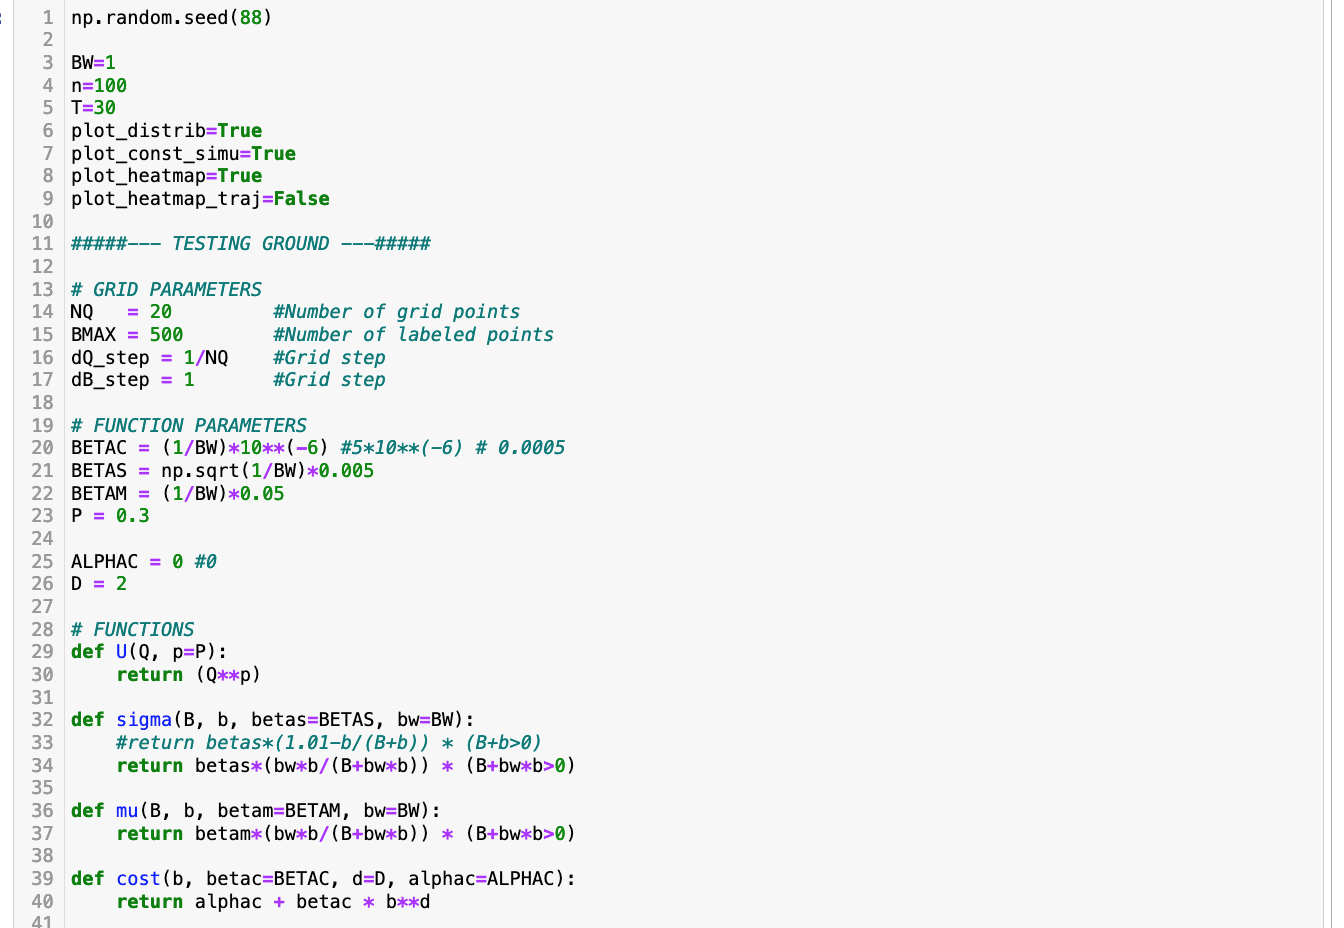

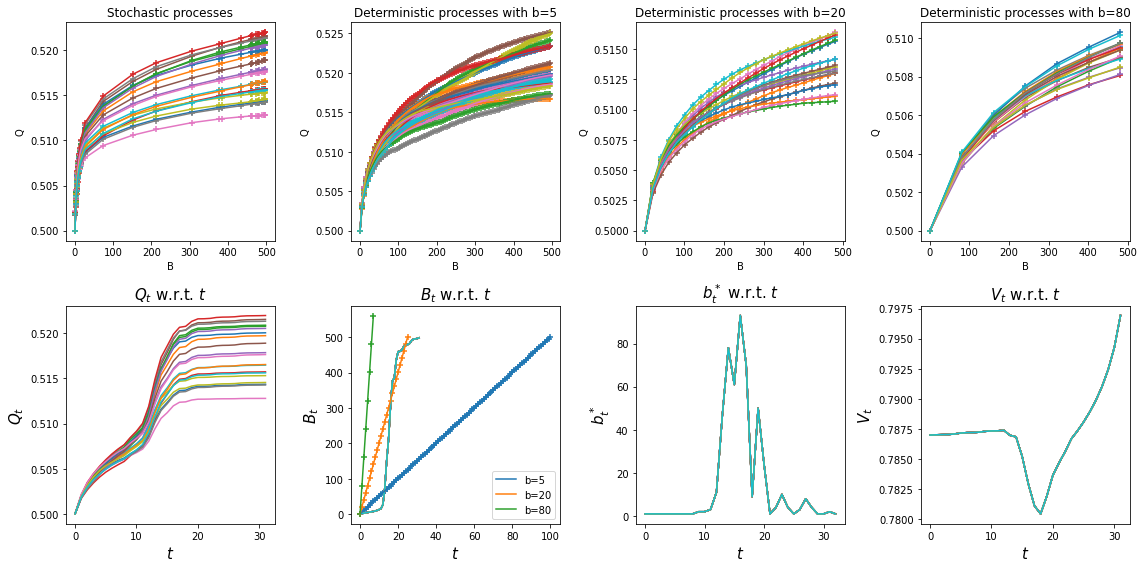

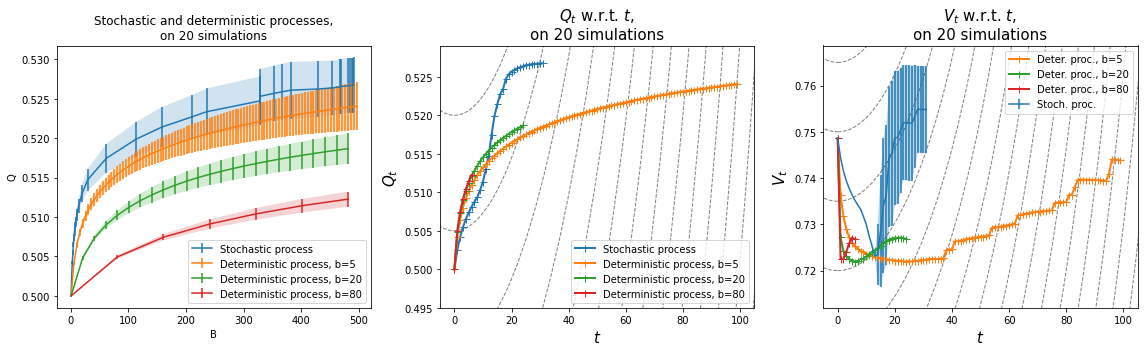

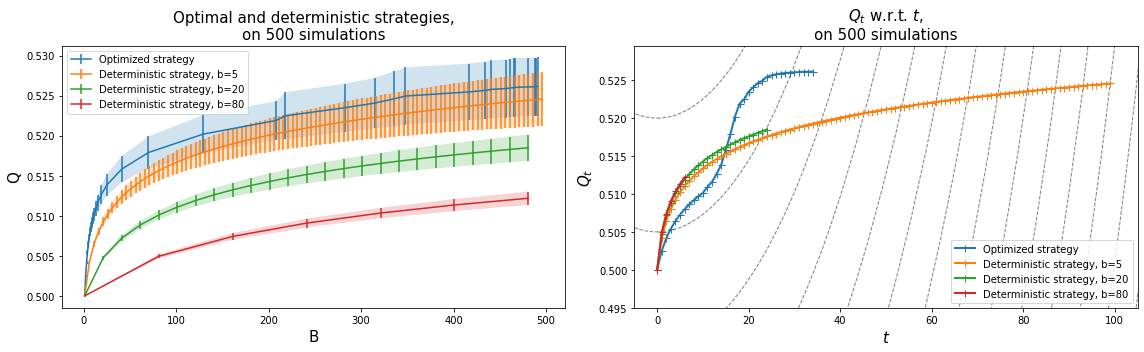

In [45]:
#np.random.seed(88)
#all_experimentation(BW=1, T=50, n=100,plot_distrib=False, plot_const_simu=True, plot_heatmap=False)

#for BW in [0.05, 0.1, 1, 2]:
#    np.random.seed(80)
#    print(f"==================================== BW={BW} ====================================")
#    all_experimentation(BW=BW, T=50, n=120, plot_distrib=False, plot_const_simu=True, plot_heatmap=False)

#np.random.seed(88)
#
#BW=1
#n=100
#T=40
#plot_distrib=True
#plot_const_simu=True
#plot_heatmap=True
#plot_heatmap_traj=False
#
######--- TESTING GROUND ---#####
#
## GRID PARAMETERS
#NQ   = 20         #Number of grid points
#BMAX = 800        #Number of labeled points
#dQ_step = 1/NQ    #Grid step
#dB_step = 1       #Grid step
#
## FUNCTION PARAMETERS
#BETAC = (1/BW)*10**(-6) #5*10**(-6) # 0.0005
#BETAS = np.sqrt(1/BW)*0.005
#BETAM = (1/BW)*0.05
#P = 0.4
#
#ALPHAC = 0 #0
#D = 2
#
## FUNCTIONS
#def U(Q, p=P):
#    return (Q**p)
#
#def sigma(B, b, betas=BETAS, bw=BW):
#    return betas*(bw*b/(B+bw*b)) * (B+bw*b>0)
#
#def mu(B, b, betam=BETAM, bw=BW):
#    return betam*(bw*b/(B+bw*b)) * (B+bw*b>0)
#
#def cost(b, betac=BETAC, d=D, alphac=ALPHAC):
#    return alphac + betac * b**d
#
## OPTIMIZATION
#b_optimal, b_optimal_over_B, V, keep_i, keep_j = optimal_batch(
#                                               dQ_step,
#                                               dB_step,
#                                               BMAX,
#                                               print_res = False,
#                                               print_steps = True,
#                                               plot_distrib = plot_distrib,
#                                               eps = 0.0001,
#                                               n_iterations = 10,
#                                               n_explosions = 0,
#                                               n_print_coeffs = 0,#5,#100,
#                                               betac = BETAC,
#                                               betam = BETAM,
#                                               betas = BETAS,
#                                               p = P,
#                                               bw = BW)
#
## PLOTTINGS
#plt.figure(figsize=(16, 8))
#n_simu = 20
#B0 = 1
#Q0 = 0.5
#bopts_list=[]
#Bopts_list=[]
#Qopts_list=[]
#Vopts_list=[]
#bconsts = [5, 20, 80] #2,
#
#plt.subplot(2, len(bconsts)+1, 1)
#for _ in range(n_simu):
#    B, Q, bopts, boptstr_i, boptstr_j = stochastic_simulation(b_optimal, B0 = B0, n=n, T=T) # dt = T/n
#    bopts_list.append(bopts)
#    Bopts_list.append(B)
#    Qopts_list.append(Q)
#    Vopts_list.append(V[np.array(boptstr_i)-1, np.array(boptstr_j)-1])
#    if len(B) == len(Q):
#        plt.plot(B, Q, linestyle="-")
#        plt.scatter(B, Q, marker="+")
#    else:
#        plt.plot(B[:min(len(B), len(Q))], Q[:min(len(B), len(Q))], linestyle="-")
#        plt.scatter(B[:min(len(B), len(Q))], Q[:min(len(B), len(Q))], marker="+")
#plt.xlabel("B")
#plt.ylabel("Q")
#plt.title("Stochastic processes")
#
#if plot_const_simu:
#    for i, b0 in enumerate(bconsts, start=2):
#        #print(i, b0)
#        plt.subplot(2, len(bconsts)+1, i)
#        for _ in range(n_simu):
#            b_const = b0*np.ones(b_optimal.shape)
#            B, Q, b, btr_i, btr_j = stochastic_simulation(b_const, B0=B0, Q0=Q0, n=n, T=T)
#            if len(B) == len(Q):
#                plt.plot(B, Q, linestyle="-")
#                plt.scatter(B, Q, marker="+")
#            else:
#                plt.plot(B[:min(len(B), len(Q))], Q[:min(len(B), len(Q))], linestyle="-")
#                plt.scatter(B[:min(len(B), len(Q))], Q[:min(len(B), len(Q))], marker="+")
#        plt.xlabel("B")
#        plt.ylabel("Q")
#        plt.title(f"Deterministic processes with b={b0}")
#else:
#    i=1
#    
#plt.subplot(2, len(bconsts)+1, i+1)
#for Q in Qopts_list:
#    plt.plot(np.arange(len(Q)), Q)
#plt.xlabel("$t$", fontsize=15)
#plt.ylabel("$Q_t$", fontsize=15)
#plt.title("$Q_t$ w.r.t. $t$", fontsize=15)
#
#plt.subplot(2, len(bconsts)+1, i+2)
#for B in Bopts_list:
#    plt.plot(np.arange(len(B)), B)
#for bconst in bconsts:
#    B1 = np.arange(B0, BMAX+bconst, bconst)
#    plt.plot(np.arange(len(B1)), B1, label=f"b={bconst}")
#    plt.scatter(np.arange(len(B1)), B1, marker="+")
#
#plt.xlabel("$t$", fontsize=15)
#plt.ylabel("$B_t$", fontsize=15)
#plt.title("$B_t$ w.r.t. $t$", fontsize=15)
#plt.legend()
#
#plt.subplot(2, len(bconsts)+1, i+3)
#for bopts in bopts_list:
#    plt.plot(np.arange(len(bopts)), bopts)
#plt.xlabel("$t$", fontsize=15)
#plt.ylabel("$b^*_t$", fontsize=15)
#plt.title("$b^*_t$ w.r.t. $t$", fontsize=15)
#plt.subplot(2, len(bconsts)+1, i+4)
#for vs in Vopts_list:
#    plt.plot(np.arange(len(vs)), vs)
#plt.xlabel("$t$", fontsize=15)
#plt.ylabel("$V_t$", fontsize=15)
#plt.title("$V_t$ w.r.t. $t$", fontsize=15)
#plt.tight_layout();
#
#if plot_heatmap:
#    if plot_heatmap_traj:
#        btr_i=boptstr_i
#        btr_j=boptstr_j
#    else:
#        btr_i = None
#        btr_j = None
#    #viz_heatmap(b_optimal, title="$b^*$")
#    viz_heatmap(b_optimal_over_B, title="$b^*/(BMAX-B)$", btr_i=btr_i, btr_j=btr_j, BMAX=BMAX);
#    #viz_heatmap(V, title="$V$", BMAX=BMAX);
#plt.show()